In [1]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager", repos='http://cran.us.r-project.org')
#BiocManager::install("edgeR")

In [2]:
#browseVignettes("edgeR")

In [3]:
#install.packages("locfit", repos='http://cran.us.r-project.org')

In [4]:
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'psych' was built under R version 3.5.3"
Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Warning message:
"package 'gridExtra' was built under R version 3.5.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'scales'

The following objects are masked from 'package:psych':

    alpha, rescale

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

Warning message:
"p

In [27]:
MQ_tmt <- read_tsv("Hippocampus_export.csv")

Parsed with column specification:
cols(
  ND_1 = col_double(),
  ND_2 = col_double(),
  ND_3 = col_double(),
  HF_1 = col_double(),
  HF_2 = col_double(),
  HF_3 = col_double(),
  KO_1 = col_double(),
  KO_2 = col_double(),
  KO_3 = col_double(),
  `Protein IDs` = col_character()
)


In [28]:
accession <- MQ_tmt$'Protein IDs'

In [29]:
MQ_tmt = within(MQ_tmt, rm('Protein IDs'))

In [30]:
head(MQ_tmt)
nrow(MQ_tmt)

ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3
37382,44103,43120,39512,43439,34445,32882,37165,37203
1458800,1533800,1416400,1378000,1522300,1216900,1085100,1490200,1312600
1276900,1345800,1226700,1125400,1316500,1008900,851180,1273000,1083300
751950,790170,693740,671740,732560,575820,485000,751780,636580
280690,279700,300880,335690,305910,253170,280620,288580,291180
121100,127130,122370,117650,135190,107810,90850,119820,127840


[1] 7043

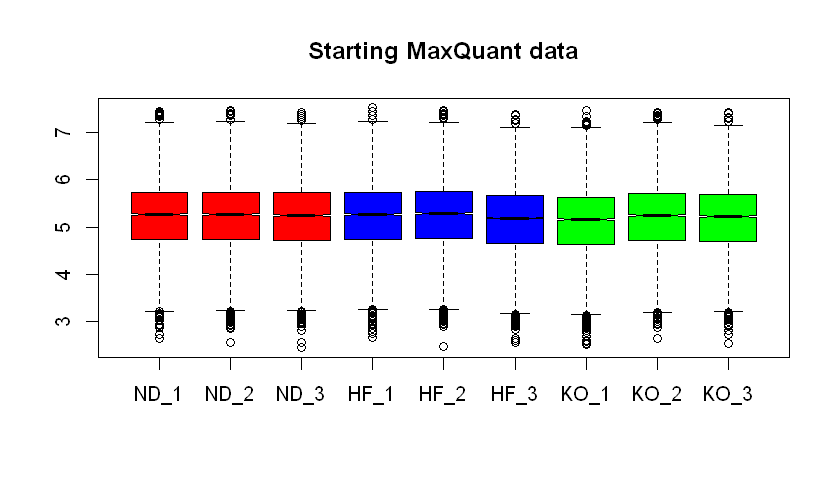

In [31]:
color = c(rep("red", 3), rep("blue", 3), rep("green", 3) )
boxplot(log10(MQ_tmt), col = color, notch = TRUE, main = "Starting MaxQuant data")

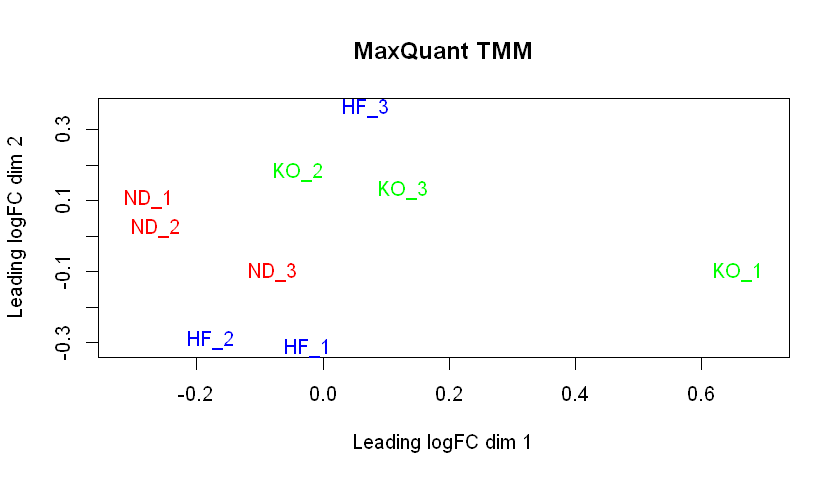

In [32]:
plotMDS(log2(MQ_tmt), col = color, main = "MaxQuant TMM")

In [33]:
group <- c(rep("ND", 3), rep("HF", 3), rep("KO", 3))
y <- DGEList(counts = MQ_tmt, group = group, genes = accession)


In [34]:
y$samples

,group,lib.size,norm.factors
ND_1,ND,3860765262,1
ND_2,ND,3865530457,1
ND_3,ND,3727777641,1
HF_1,HF,3920506370,1
HF_2,HF,4022187524,1
HF_3,HF,3199657199,1
KO_1,KO,3084034918,1
KO_2,KO,3630370207,1
KO_3,KO,3393610278,1


In [60]:
??calcNormFactors

starting httpd help server ... done


In [35]:
y <- calcNormFactors(y)

In [36]:
y$samples

,group,lib.size,norm.factors
ND_1,ND,3860765262,0.9958054
ND_2,ND,3865530457,0.9951052
ND_3,ND,3727777641,1.0041594
HF_1,HF,3920506370,0.9873276
HF_2,HF,4022187524,1.0068270
HF_3,HF,3199657199,1.0154960
KO_1,KO,3084034918,0.9674010
KO_2,KO,3630370207,1.0128990
KO_3,KO,3393610278,1.0159841


Design matrix not provided. Switch to the classic mode.


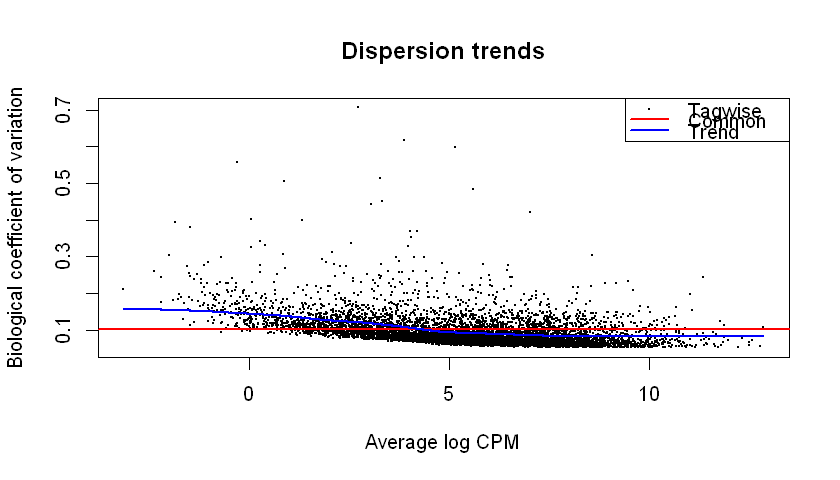

In [37]:
y <- estimateDisp(y)
plotBCV(y, main = "Dispersion trends")

Overall Factors (lib.size+TMM):
 ND_1  -> 0.945184
 ND_2  -> 0.944683
 ND_3  -> 0.970759
 HF_1  -> 0.938773
 HF_2  -> 0.897319
 HF_3  -> 1.118362
 KO_1  -> 1.217975
 KO_2  -> 0.988205
 KO_3  -> 1.053939


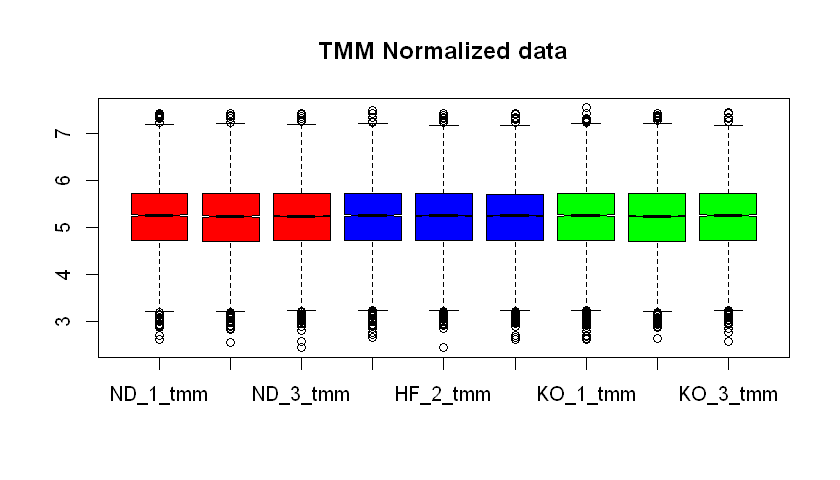

In [38]:
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# get the normalized data values
MQ_tmt_tmm <- apply_tmm_factors(y, color)

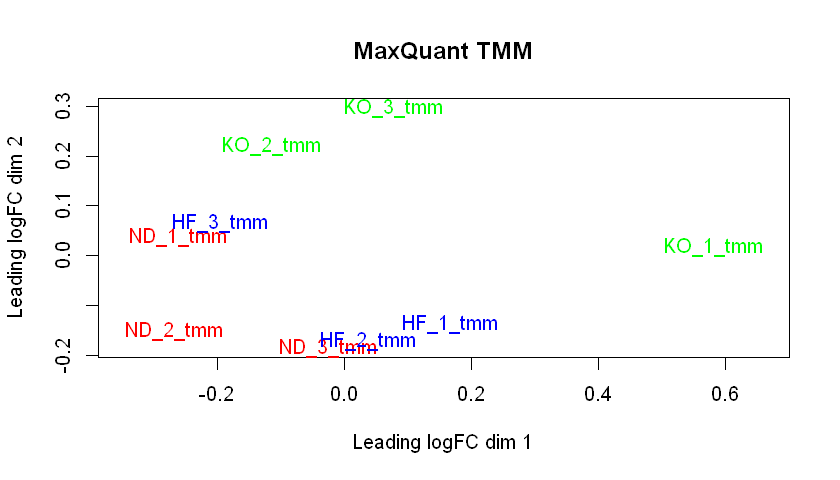

In [39]:
# see how things cluster after we have normalized data
plotMDS(log2(MQ_tmt_tmm), col = color, main = "MaxQuant TMM")


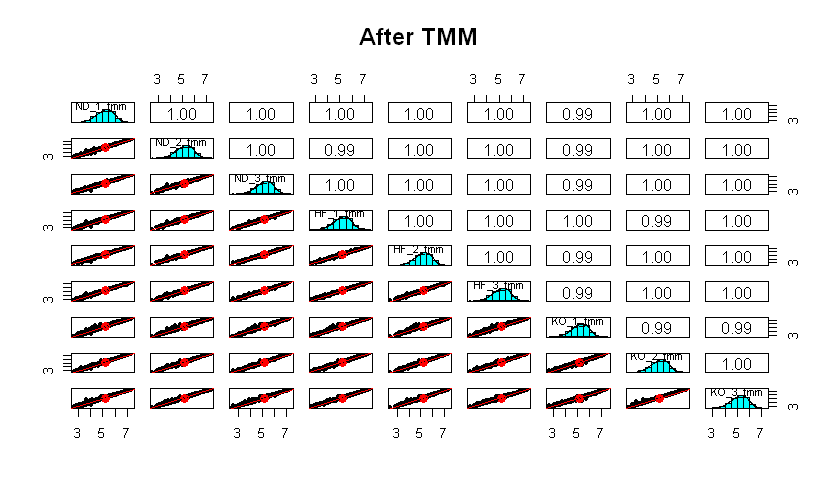

In [40]:
# scatter plots within groups and betwen groups
pairs.panels(log10(MQ_tmt_tmm), lm = TRUE, main = "After TMM")

In [41]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))

    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + 
        ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}


log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    if (make_facet == TRUE) {
        ma_facet <- ggplot(temp, aes(x = A, y = M)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
            scale_x_continuous("log10 Ave_intensity") +
            ma_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)"))
    }

    # make the plots visible
    print(ma)
    if (make_facet == TRUE) {
         print(ma_facet)
    }
} 

scatter_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    if (make_facet == TRUE) {
        scatter_facet <- ggplot(results, aes_string(x, y)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scatter_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)")) 
    }

    # make the plots visible
    print(scatter)
    if (make_facet == TRUE) {
         print(scatter_facet)
    }
}

volcano_plot <- function(results, x, y, title, ymax) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
        # ymax - upper limit for y-axis
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        coord_cartesian(xlim = c(-5, 5), ylim = c(0, ymax)) + 
        ggtitle(str_c(title, " Volcano Plot"))
}

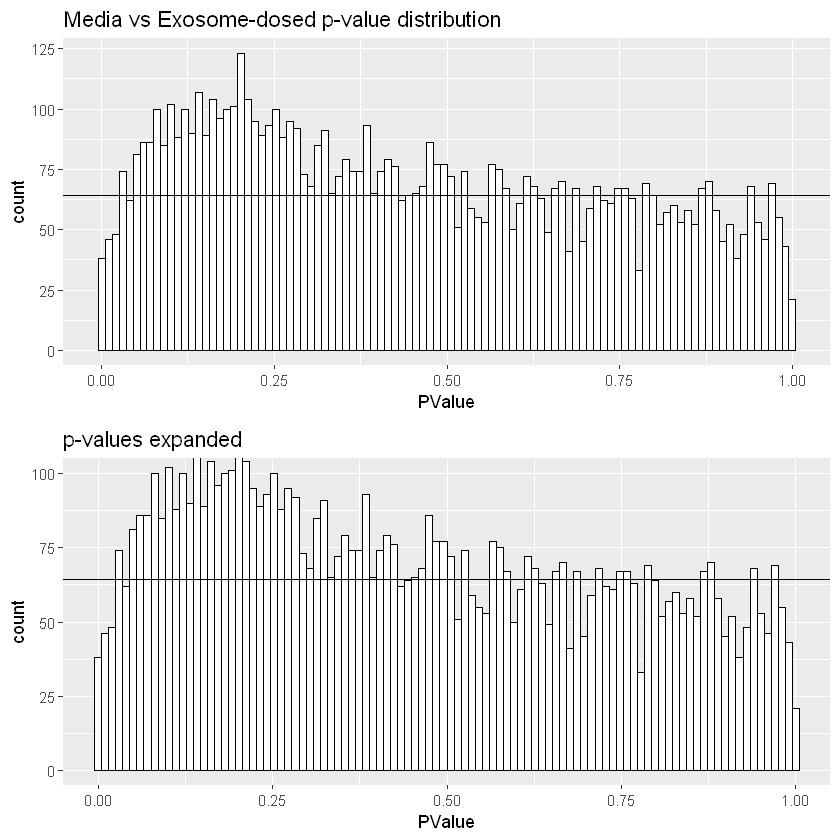

In [53]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("ND", "HF"))
# make the results table 
M <- 1:3
E <- 4:6
tt <- topTags(et, n = Inf, sort.by = "none")$table
ND_KO <- collect_results(MQ_tmt_tmm, tt, M, "ND", E, "KO")
# check the p-value distrubution
pvalue_plots(ND_KO, 100, "Media vs Exosome-dosed")

In [54]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# see which proteins have the smallest p-values
topTags(et)$table

       HF-ND
Down       2
NotSig  7040
Up         1

,genes,logFC,logCPM,PValue,FDR
818,GBRA2_MOUSE,0.6717409,6.3802908,8.197242e-19,5.773318e-15
696,G5E846_MOUSE,-0.5269162,4.2989545,2.888384e-08,1.017144e-04
532,A0A075B5P4_MOUSE,-1.2703685,2.7217542,5.147998e-08,1.208578e-04
3560,GPCP1_MOUSE,-0.2781360,5.7651788,1.189131e-04,2.093762e-01
2266,E0CZ73_MOUSE,0.4231548,-0.7113499,2.375892e-04,3.218318e-01
536,HBB1_MOUSE,0.9052714,3.0736325,2.953825e-04,3.218318e-01
4106,TSN33_MOUSE,0.5023747,1.4451741,3.198669e-04,3.218318e-01
3686,Q0VF62_MOUSE,-0.4872961,1.5575414,4.255411e-04,3.746357e-01
4045,CMBL_MOUSE,0.2334469,6.5654735,6.951183e-04,4.922538e-01
533,IGHM_MOUSE,0.7527320,4.2092940,6.989263e-04,4.922538e-01


candidate,n
high,3
no,7040


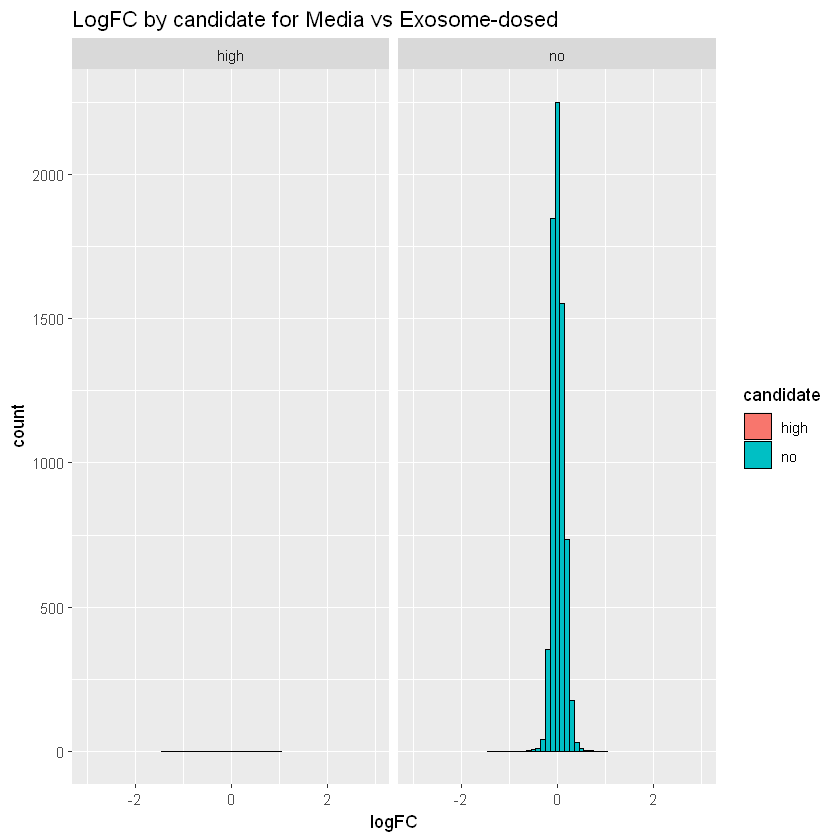

In [55]:
# see how many candidates are in each category
ND_KO %>% count(candidate)


# can look at log2FC distributions as a check
log2FC_plots(ND_KO, 3, "LogFC by candidate for Media vs Exosome-dosed")

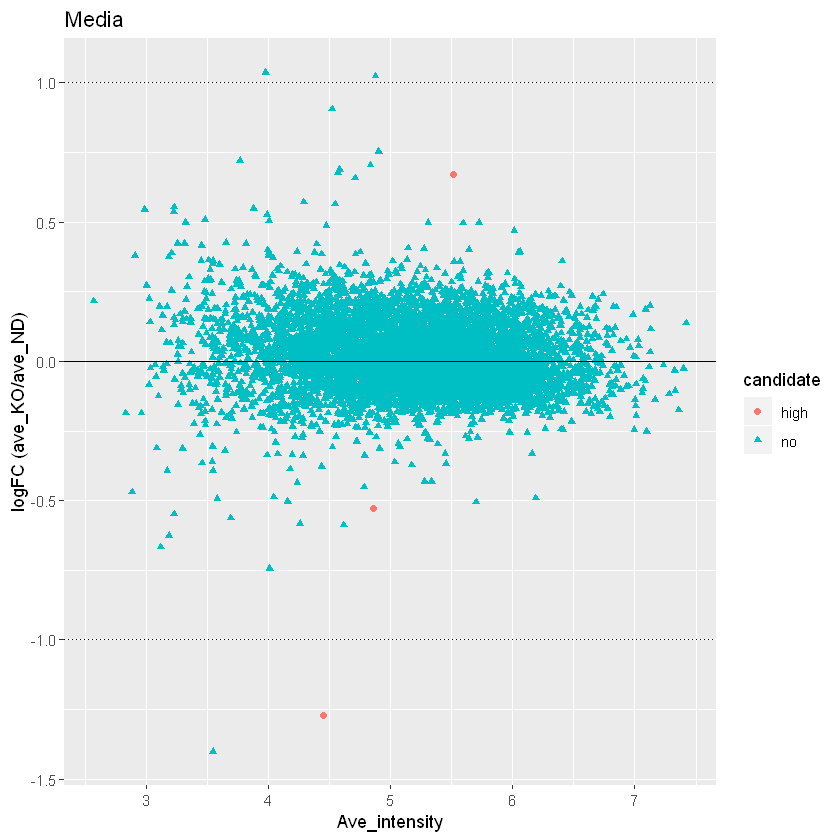

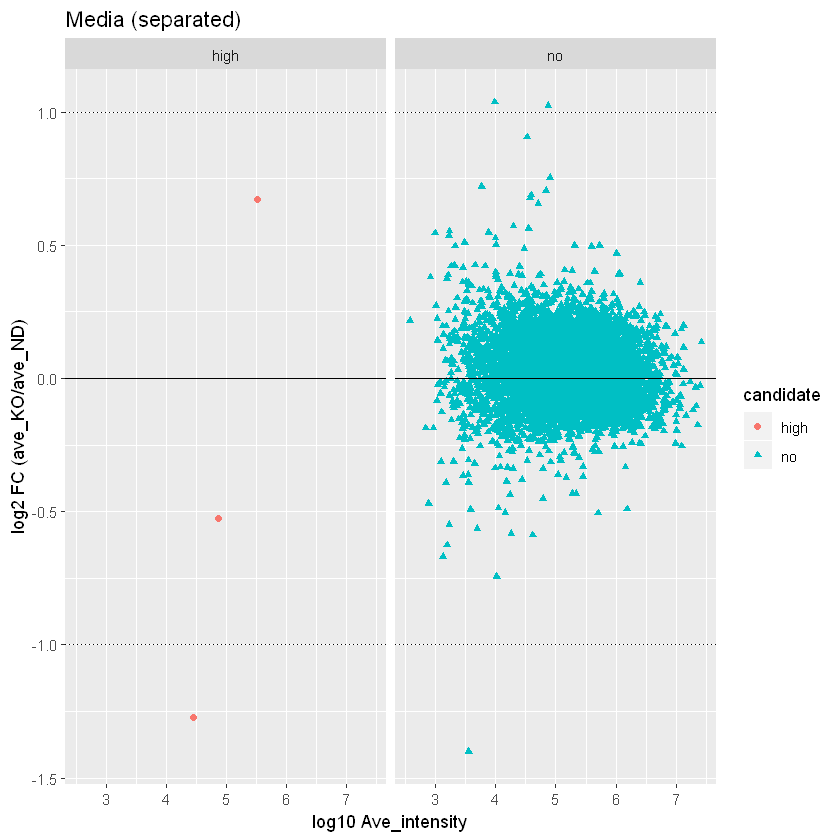

In [56]:
# MA plots of DE candidates
MA_plots(ND_KO, "ave_ND", "ave_KO", "Media")


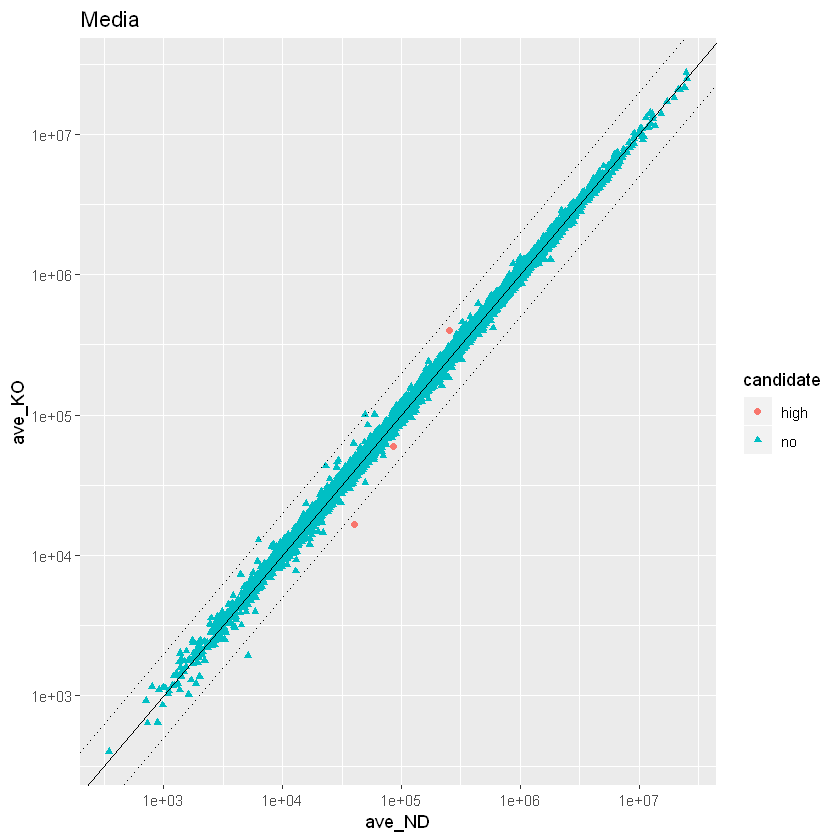

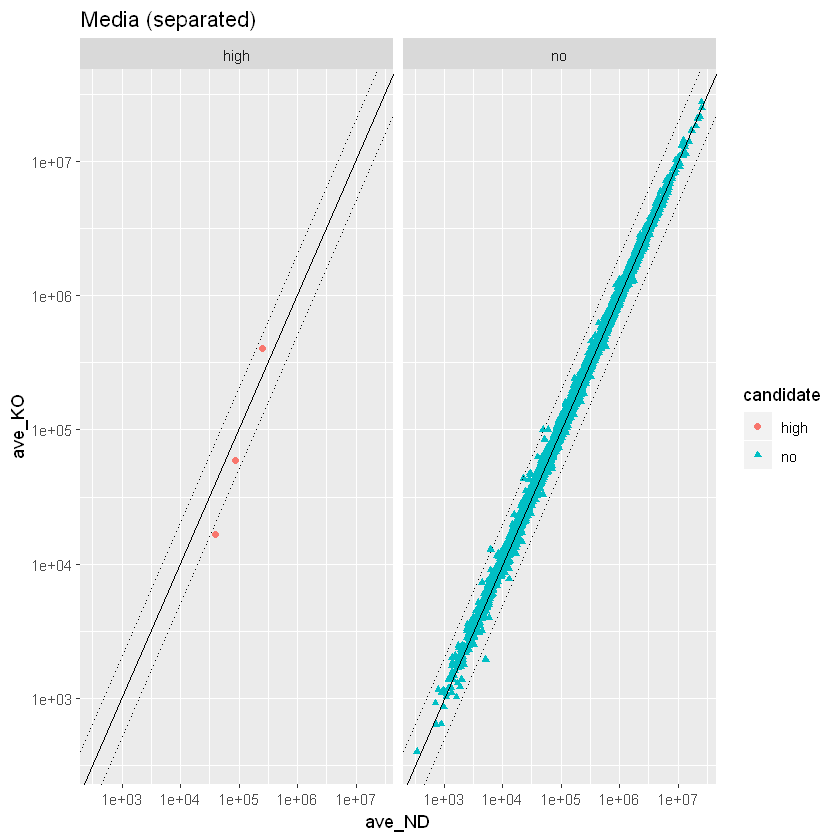

In [57]:
scatter_plots(ND_KO, "ave_ND", "ave_KO", "Media")

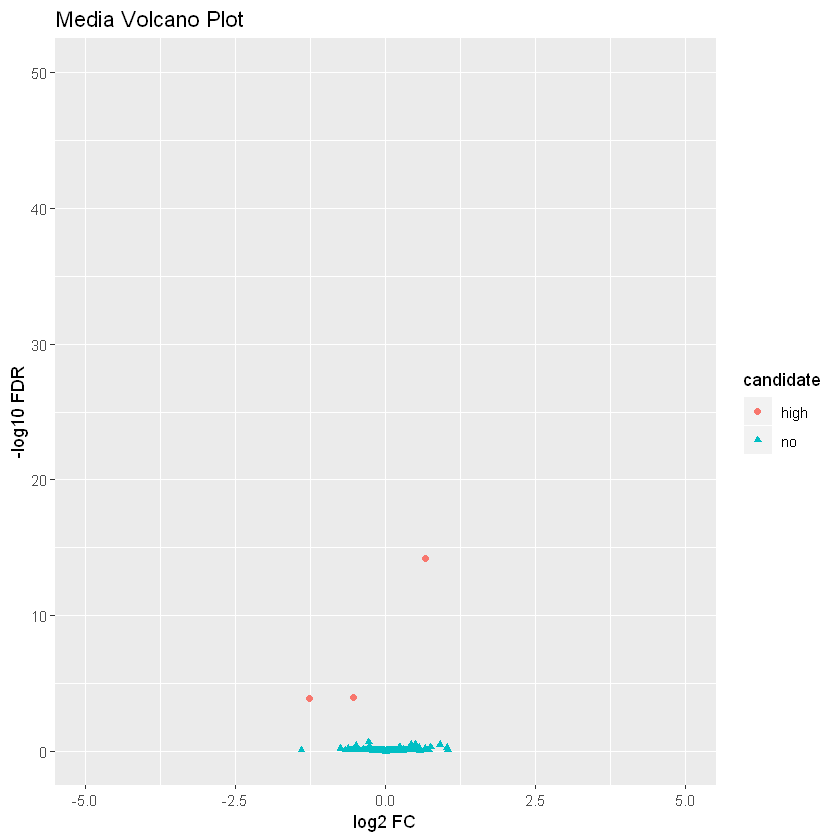

In [58]:
# finally, a volcano plot
volcano_plot(ND_KO, "ave_ND", "ave_KO", "Media", 50)


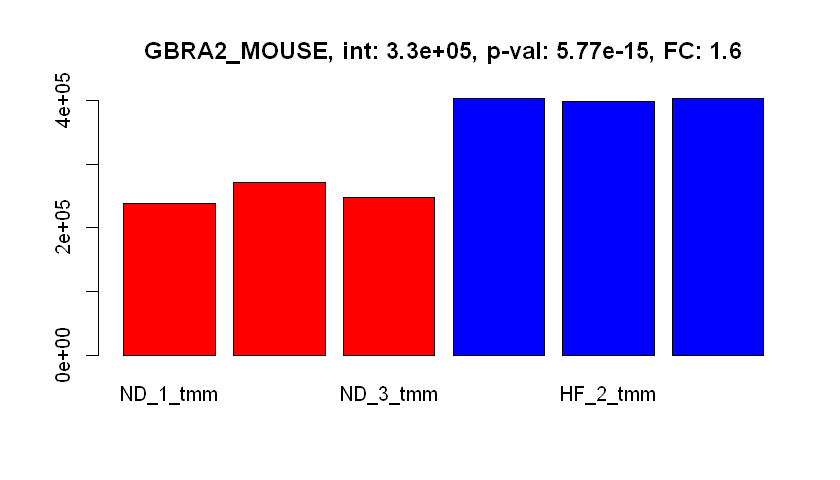

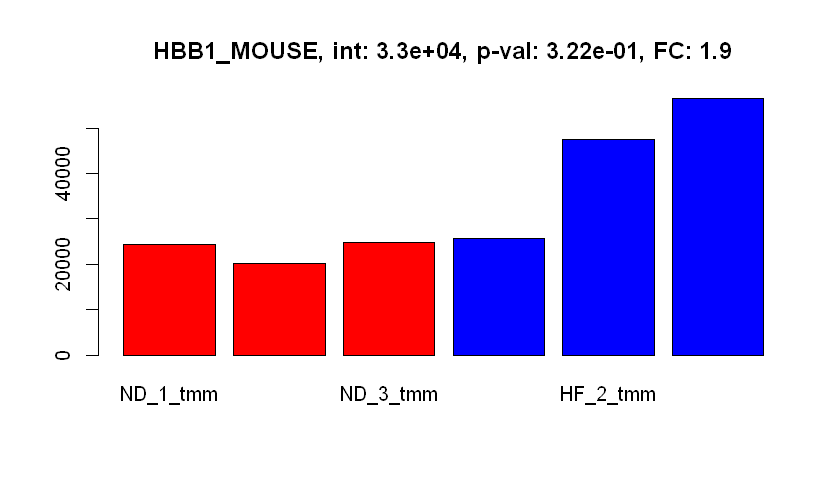

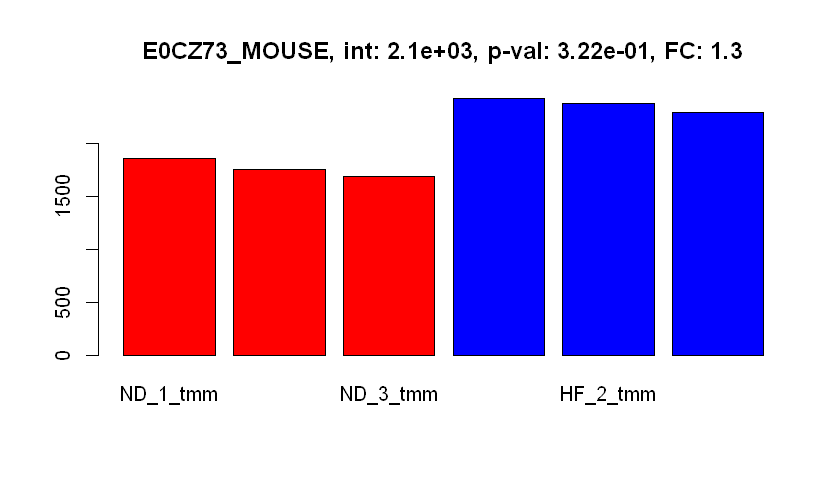

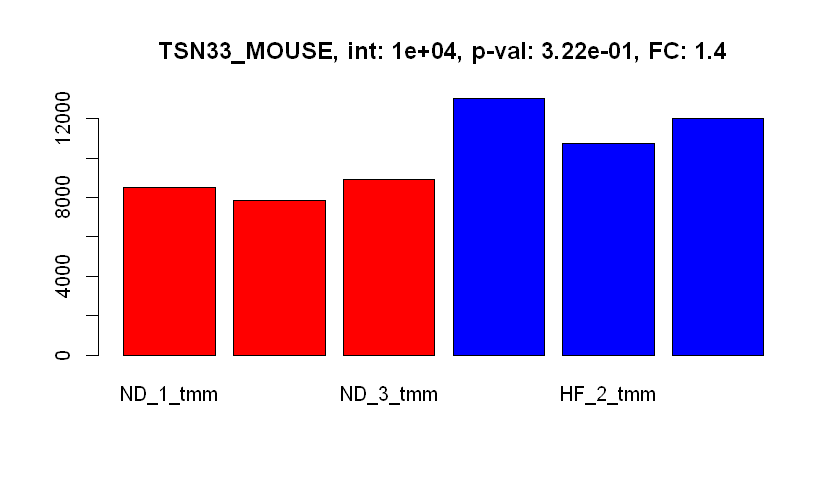

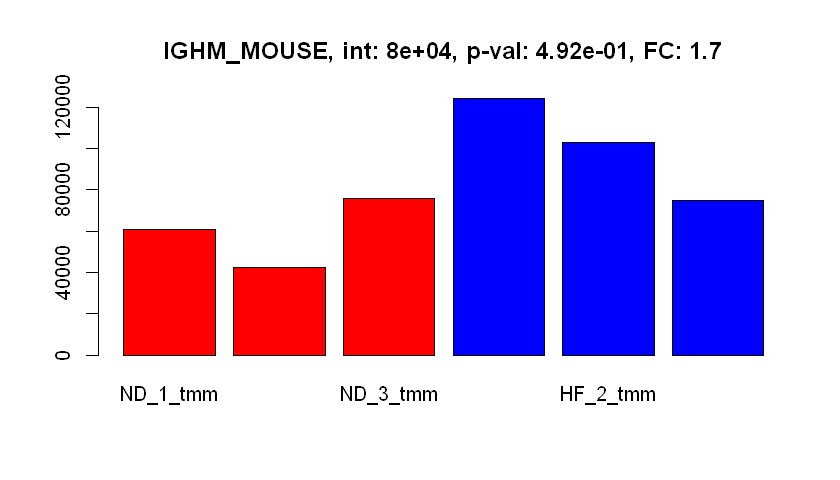

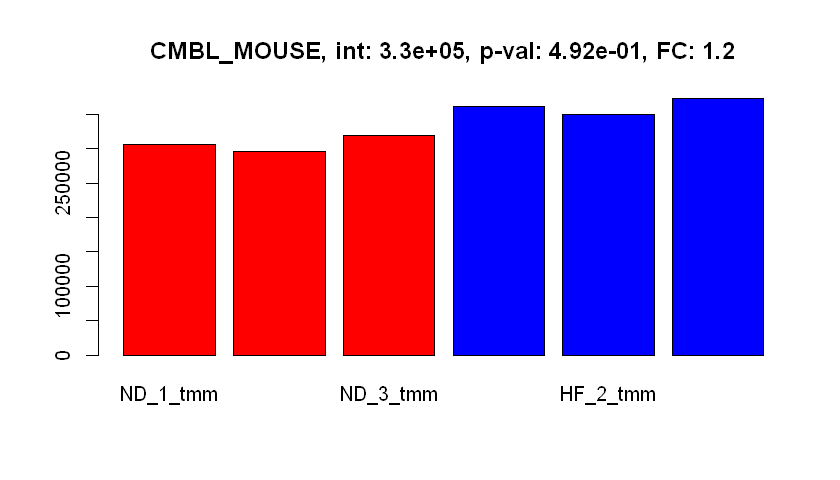

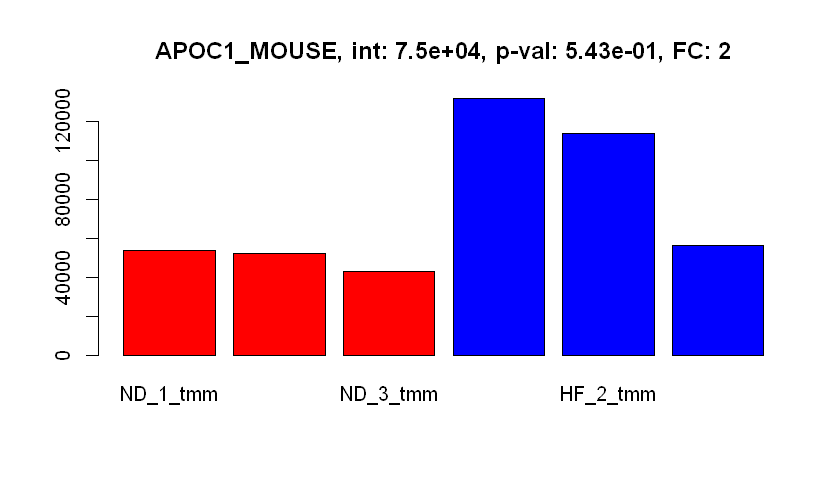

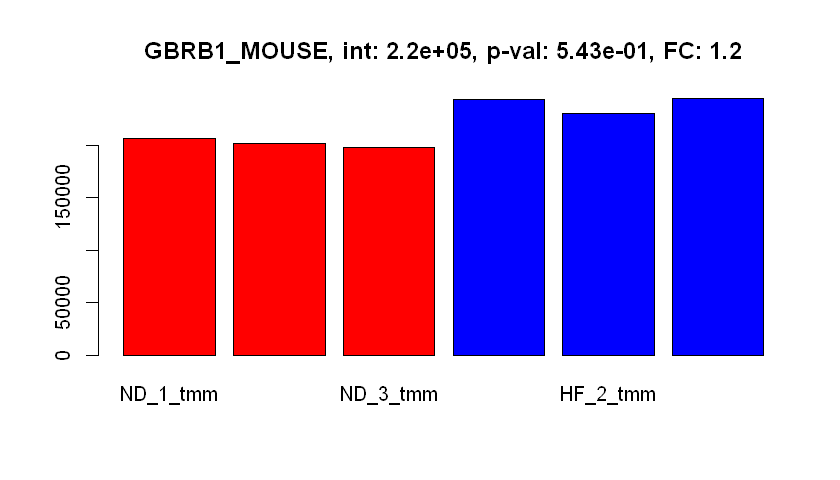

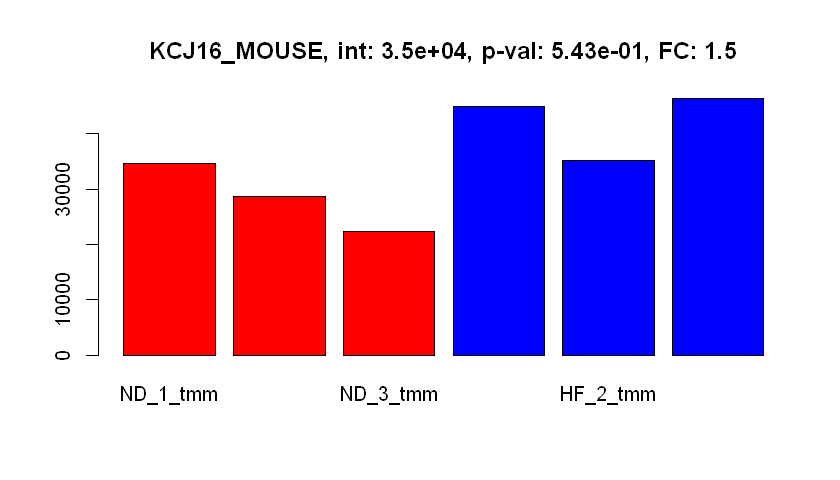

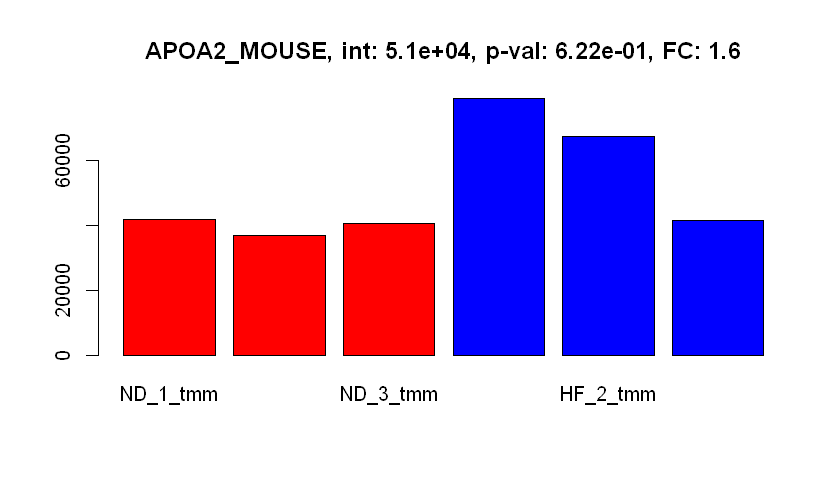

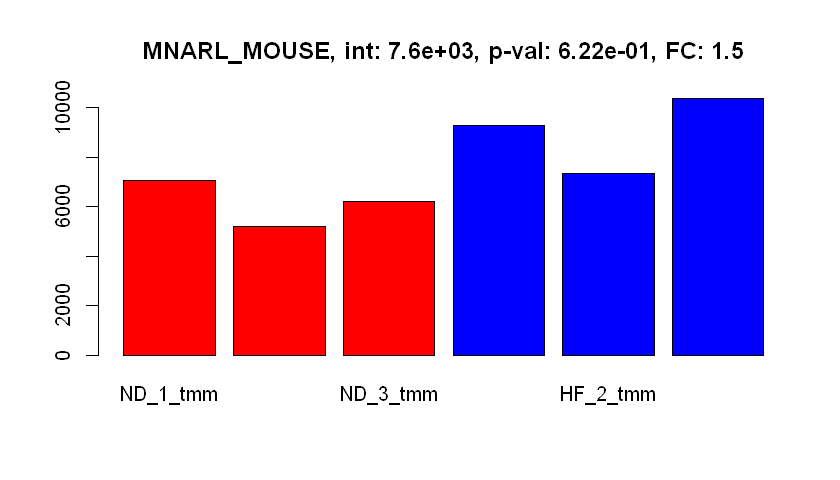

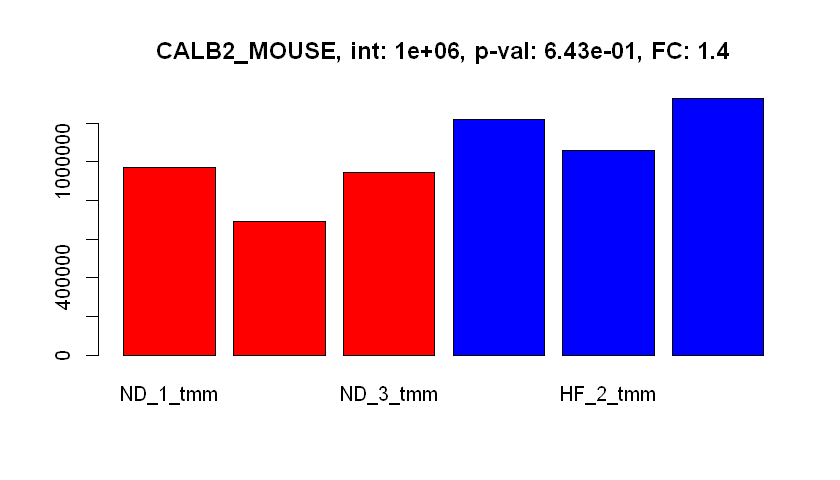

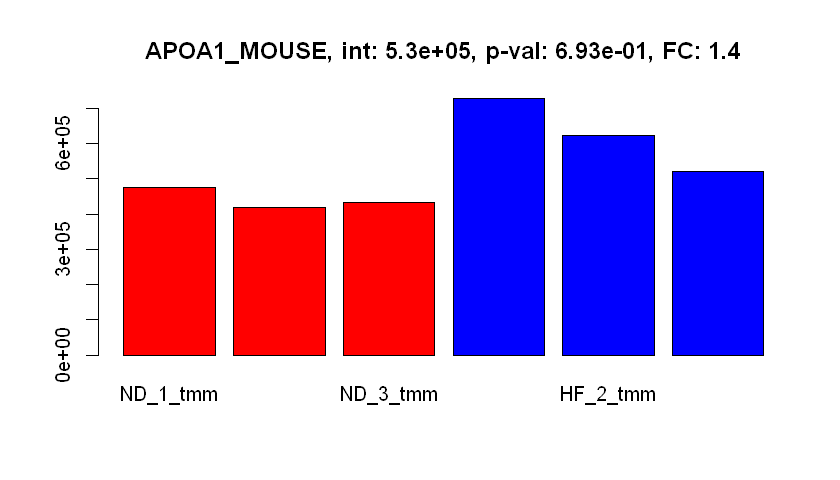

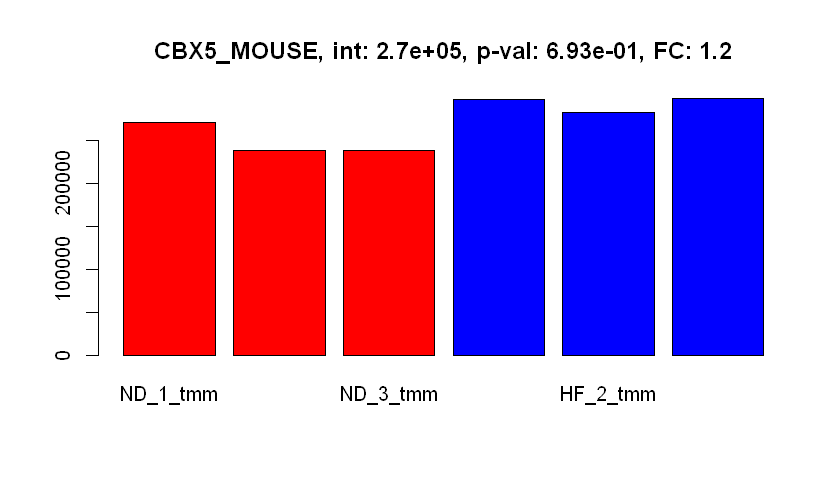

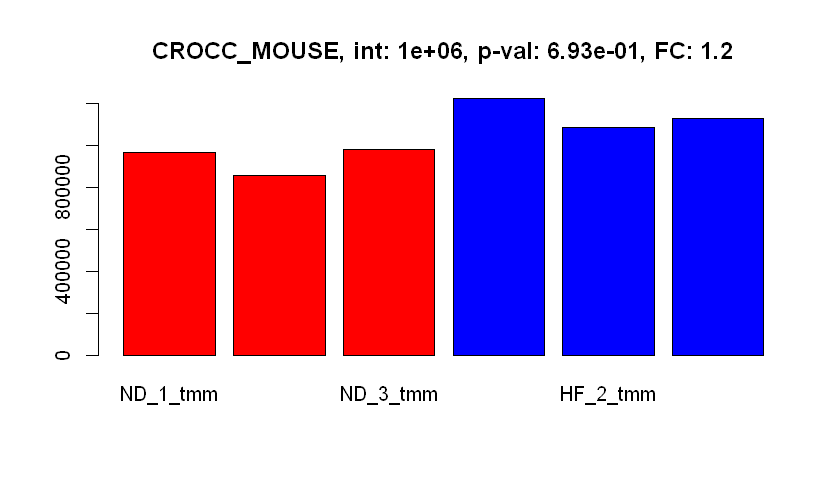

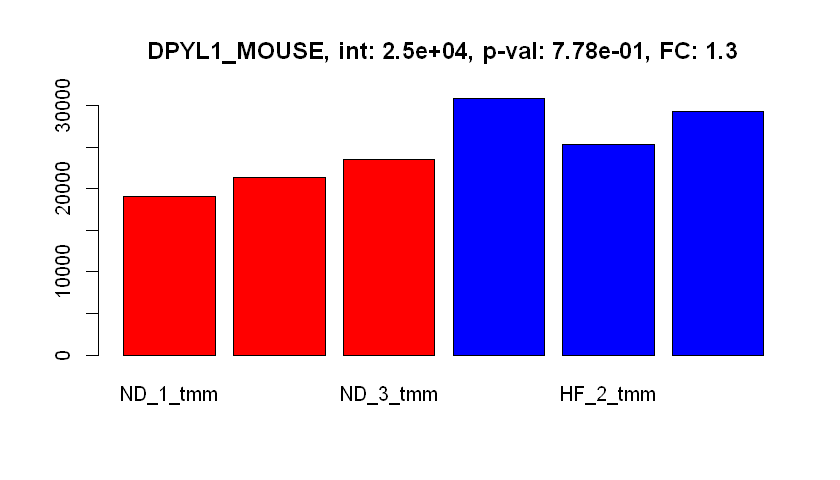

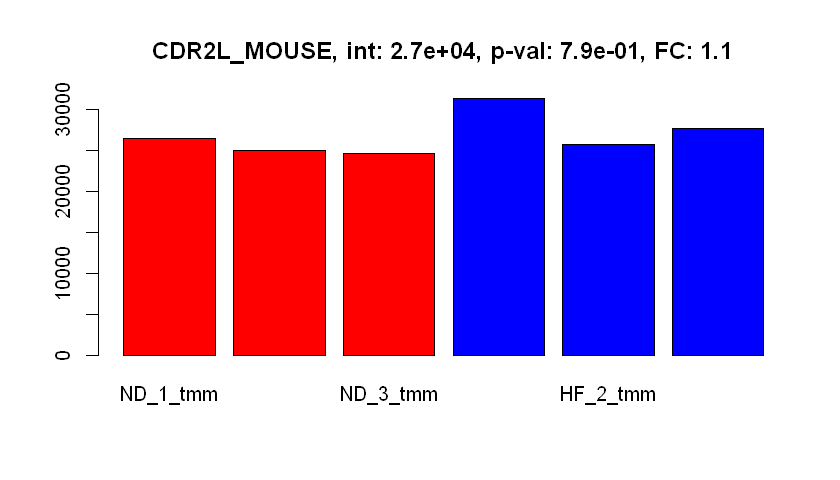

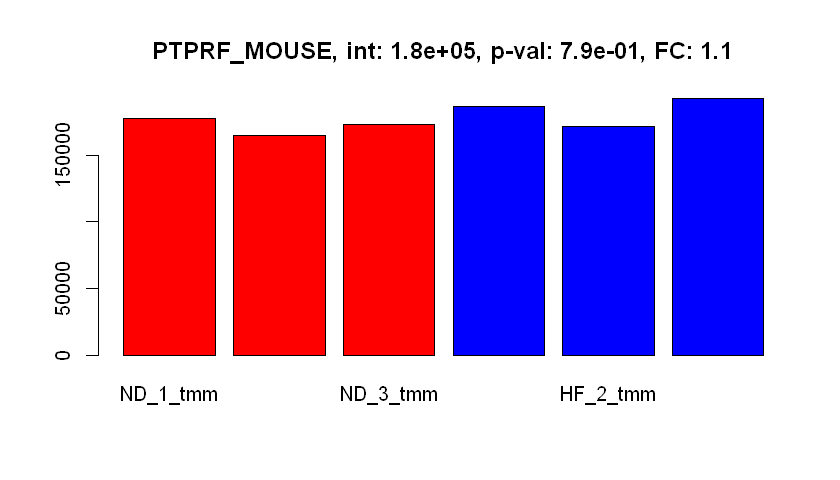

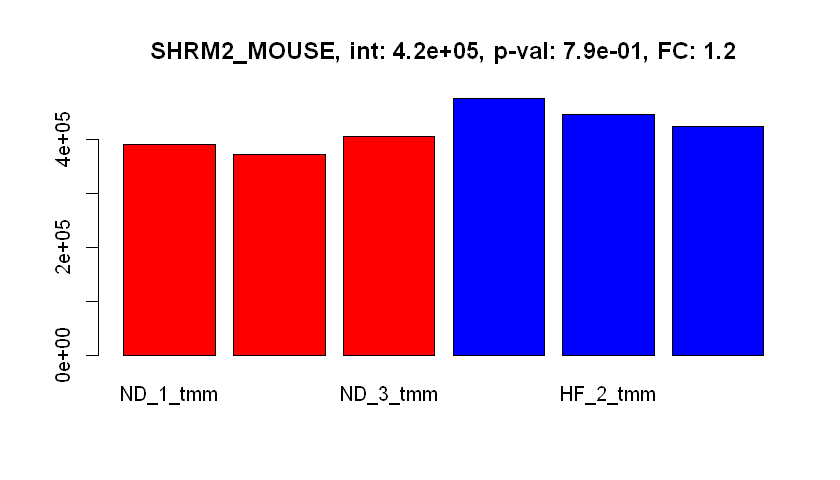

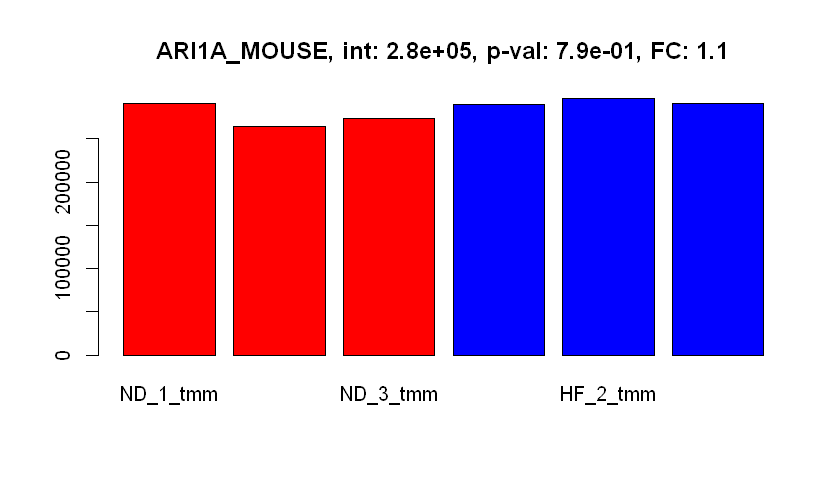

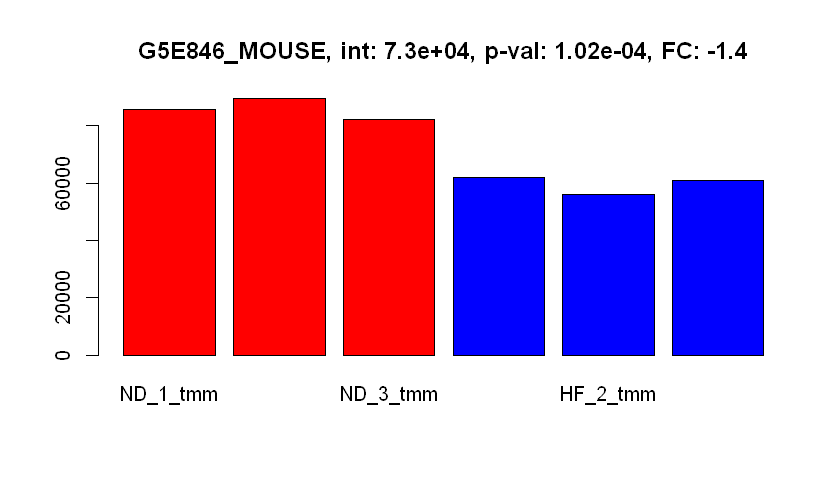

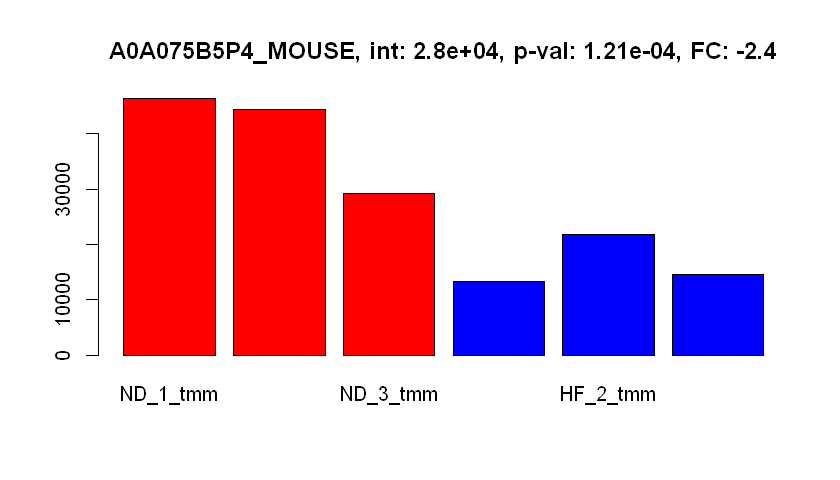

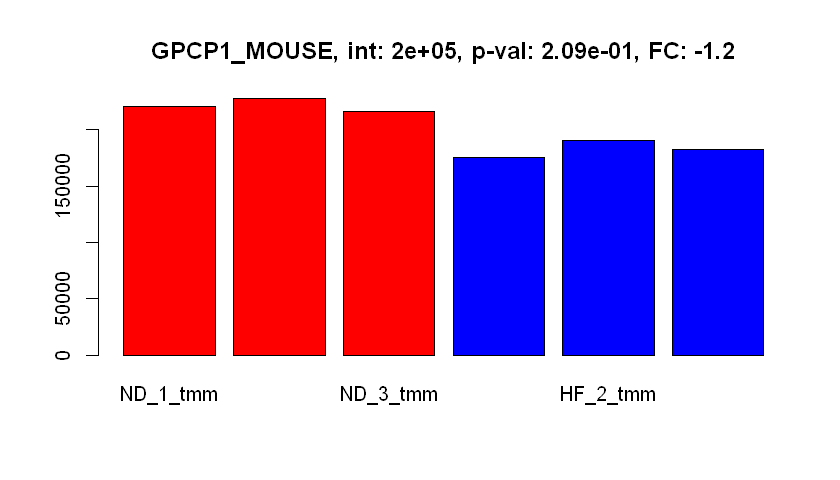

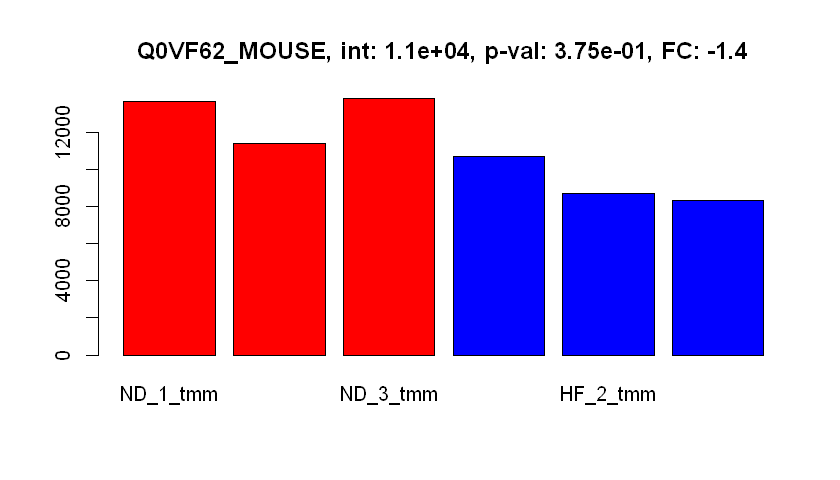

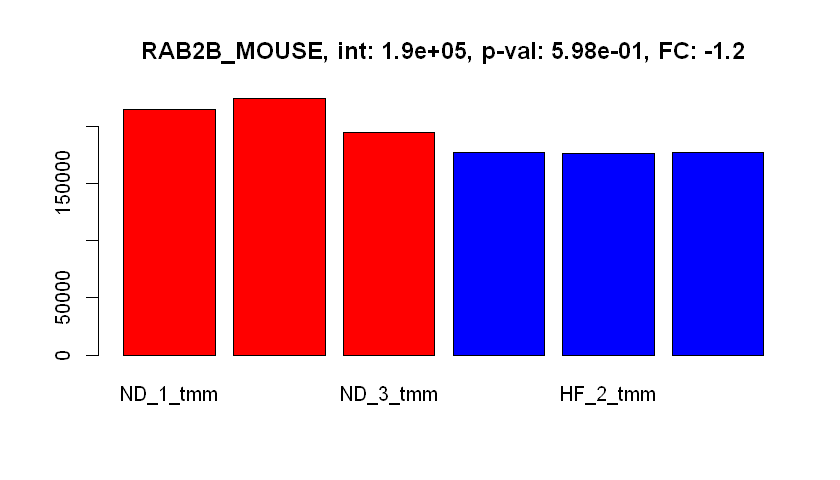

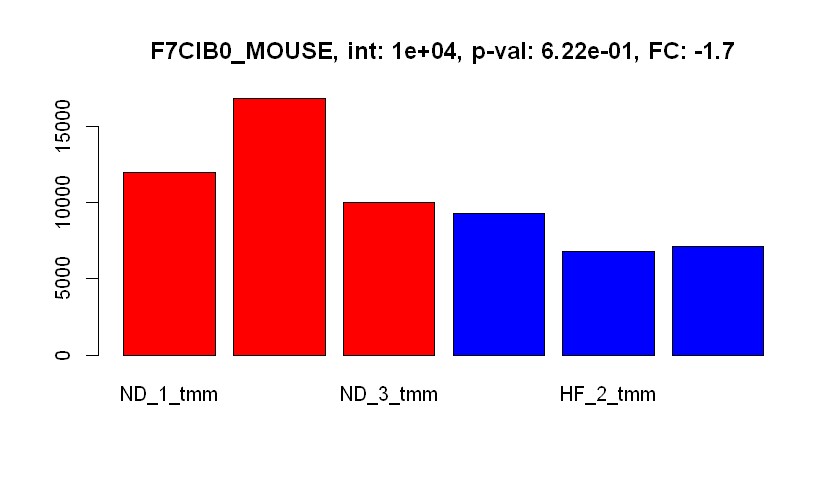

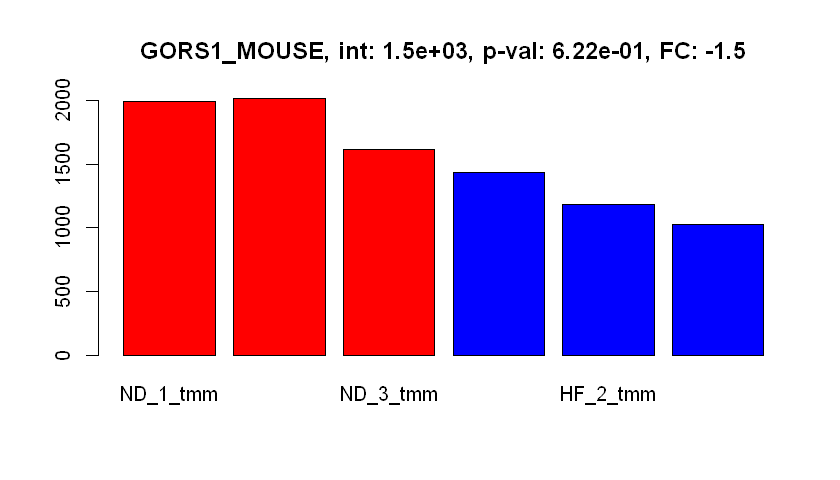

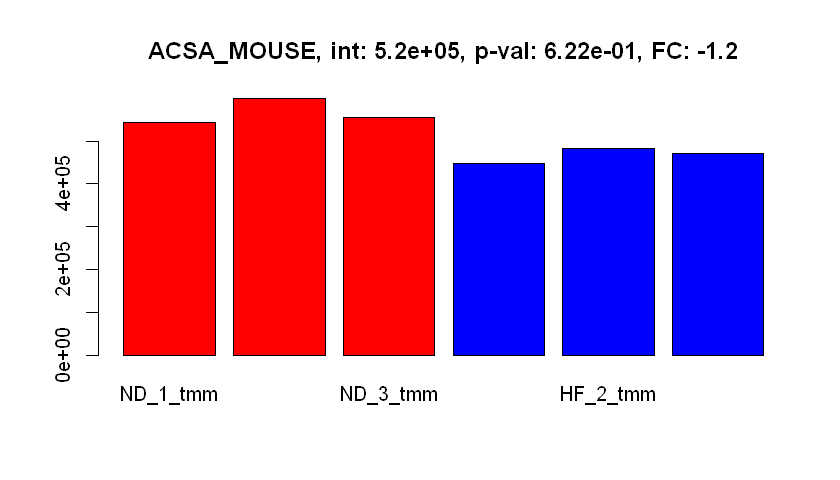

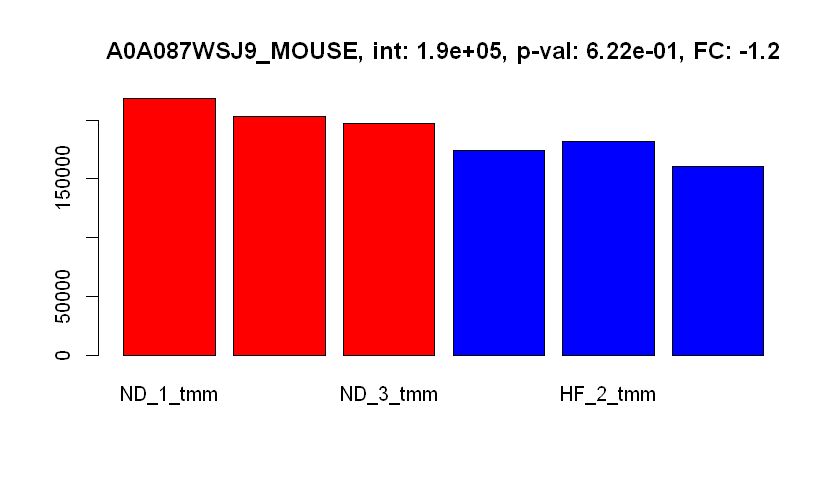

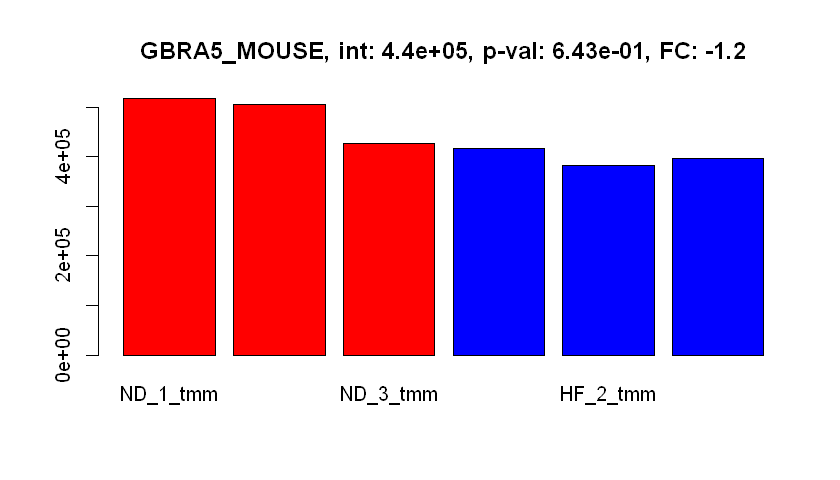

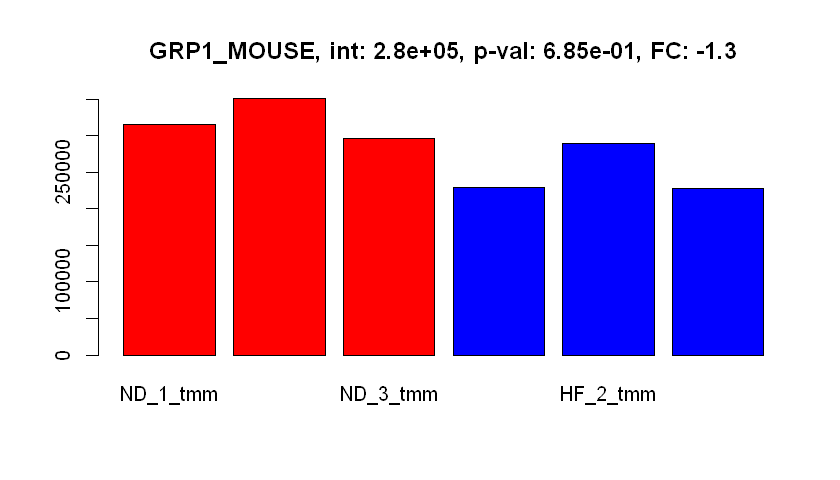

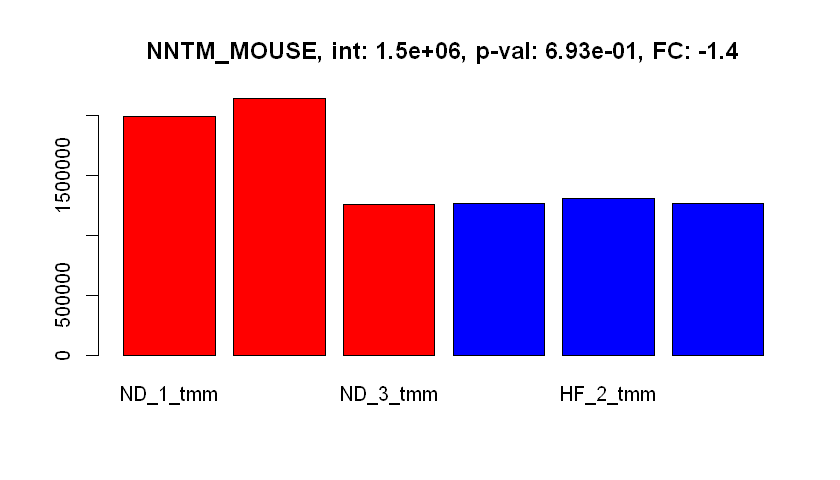

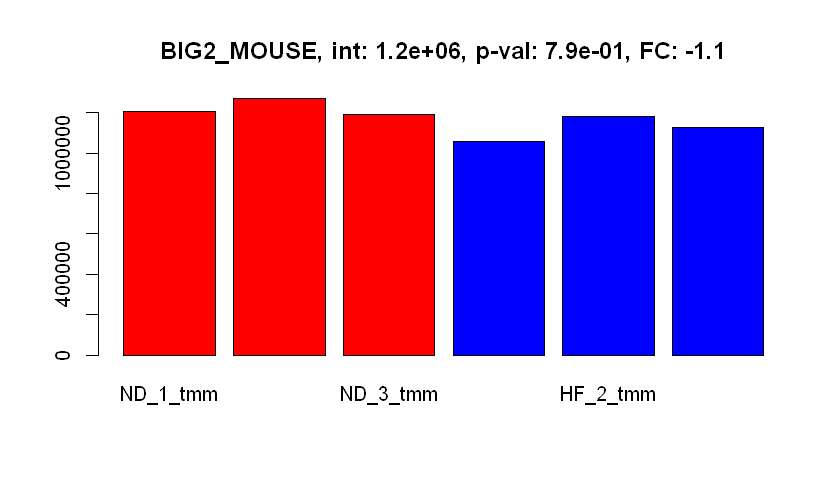

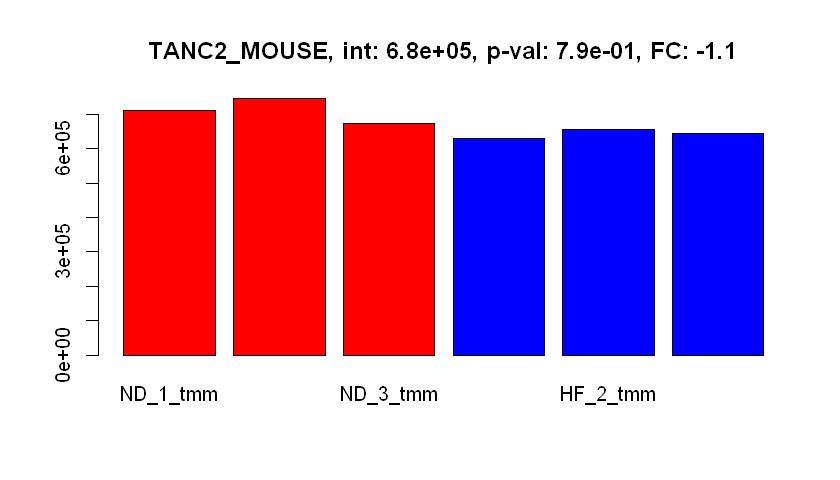

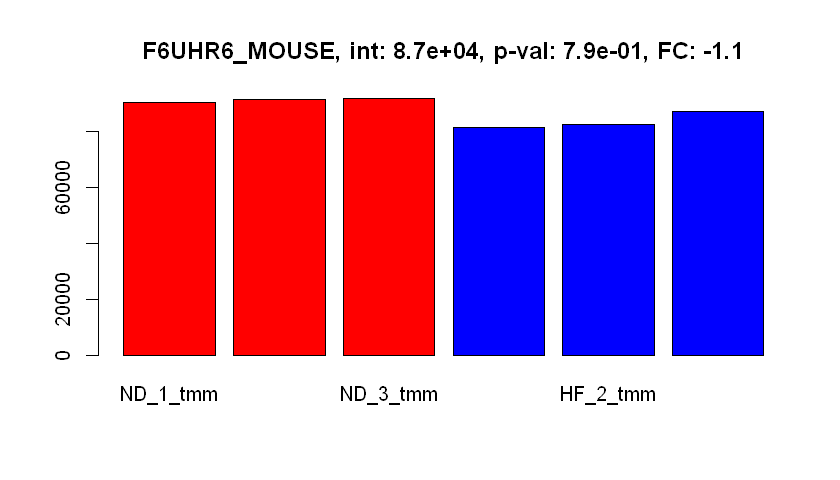

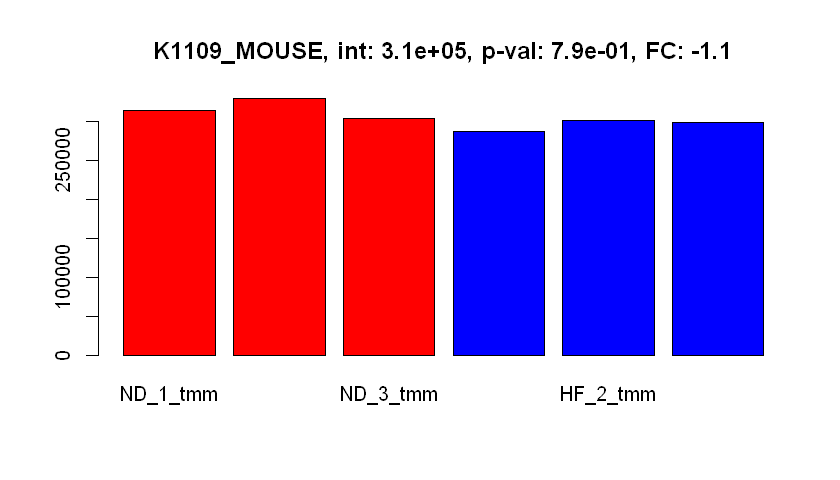

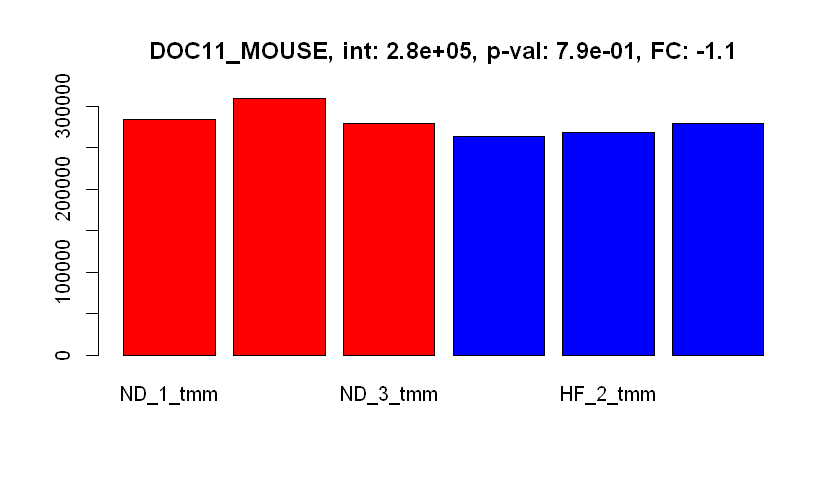

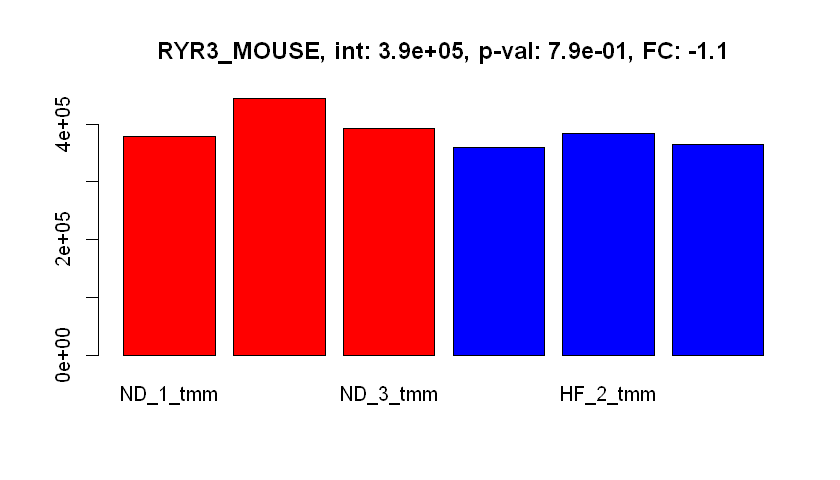

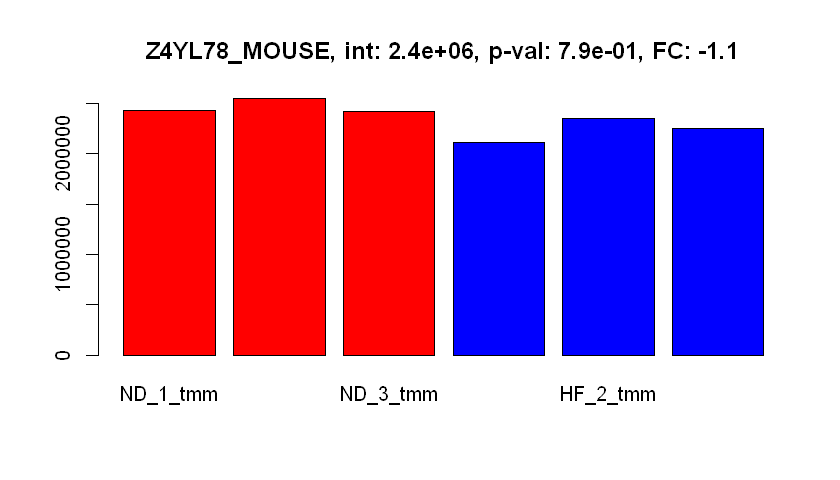

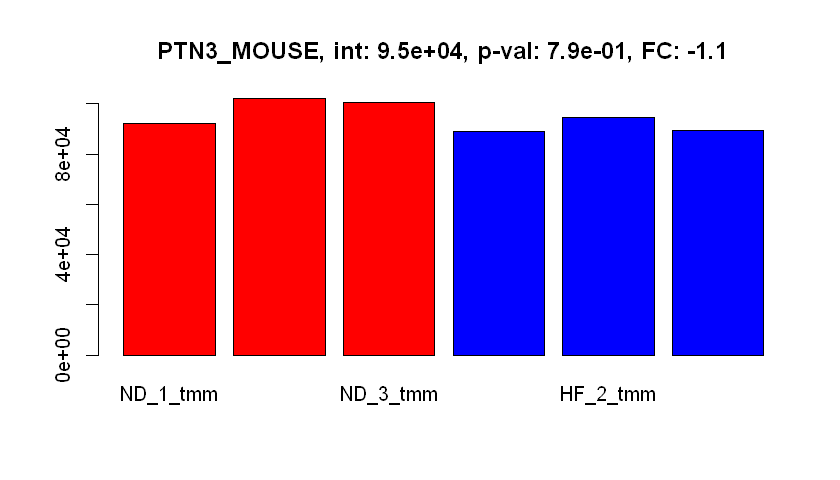

In [59]:
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    #identifier <- str_split(accession, "\\|", simplify = TRUE)
    #identifier[,3]
    accession
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}
# plot the top 20 up and 20 down proteins
set_plot_dimensions(7, 4)
plot_top_tags(ND_KO, 3, 3, 20)
set_plot_dimensions(7, 7)


In [125]:
data_irs <- read_tsv("data_irs.txt")
accession <- data_irs$'Hippo_Protein IDs'
data_irs = within(data_irs, rm('Hippo_Protein IDs'))

Parsed with column specification:
cols(
  Hippo_ND_1 = col_double(),
  Hippo_ND_2 = col_double(),
  Hippo_ND_3 = col_double(),
  Hippo_HF_1 = col_double(),
  Hippo_HF_2 = col_double(),
  Hippo_HF_3 = col_double(),
  Hippo_KO_1 = col_double(),
  Hippo_KO_2 = col_double(),
  Hippo_KO_3 = col_double(),
  Hypo_ND_1 = col_double(),
  Hypo_ND_2 = col_double(),
  Hypo_ND_3 = col_double(),
  Hypo_HF_1 = col_double(),
  Hypo_HF_2 = col_double(),
  Hypo_HF_3 = col_double(),
  Hypo_KO_1 = col_double(),
  Hypo_KO_2 = col_double(),
  Hypo_KO_3 = col_double(),
  `Hippo_Protein IDs` = col_character()
)


In [126]:
head(data_irs)

Hippo_ND_1,Hippo_ND_2,Hippo_ND_3,Hippo_HF_1,Hippo_HF_2,Hippo_HF_3,Hippo_KO_1,Hippo_KO_2,Hippo_KO_3,Hypo_ND_1,Hypo_ND_2,Hypo_ND_3,Hypo_HF_1,Hypo_HF_2,Hypo_HF_3,Hypo_KO_1,Hypo_KO_2,Hypo_KO_3
23407.61,27600.95,27960.52,24321.13,26121.83,26000.60,25705.17,24763.18,26493.76,27071.91,28025.39,26573.88,24745.59,15056.17,27434.64,26635.68,28419.60,28411.89
854017.19,897430.78,858674.59,793012.71,855855.24,858792.87,793063.96,928310.00,873925.37,882049.85,904924.74,844569.63,778016.11,658238.05,841748.66,948243.03,937322.53,917970.10
613386.66,646129.15,610221.69,531427.99,607333.88,584235.90,510465.55,650703.97,591830.41,603269.06,653186.09,601962.87,548277.95,317553.38,610251.70,664887.41,693763.97,652582.77
624447.57,655826.45,596589.48,548363.20,584224.05,576443.10,502824.41,664317.05,601216.79,592338.05,625293.99,563353.91,549916.75,566068.83,591580.47,617560.95,636385.32,611753.83
167108.75,166427.88,185497.22,196458.46,174902.14,181696.76,208573.18,182816.80,197153.68,182465.77,184924.82,183372.83,197630.47,152540.91,187993.70,190075.83,190849.49,190781.05
47996.91,50359.17,50224.53,45837.52,51456.81,51509.92,44953.31,50533.11,57624.47,51639.40,52425.98,55194.41,47583.53,27652.37,51484.48,58350.04,55036.77,51128.77


In [127]:

group <- c(rep("ND1", 3), rep("HF1", 3), rep("KO1", 3),rep("ND2", 3), rep("HF2", 3), rep("KO2", 3))
y <- DGEList(counts = data_irs, group = group, genes = accession )

#test <- calcNormFactors(y)
#head(test)

In [128]:
irs_tmm <- calcNormFactors(data_irs)
data_irs_tmm <- sweep(data_irs, 2, irs_tmm, FUN = "/") 

In [129]:
head(data_irs_tmm)

Hippo_ND_1,Hippo_ND_2,Hippo_ND_3,Hippo_HF_1,Hippo_HF_2,Hippo_HF_3,Hippo_KO_1,Hippo_KO_2,Hippo_KO_3,Hypo_ND_1,Hypo_ND_2,Hypo_ND_3,Hypo_HF_1,Hypo_HF_2,Hypo_HF_3,Hypo_KO_1,Hypo_KO_2,Hypo_KO_3
23400.43,27458.49,27761.95,24609.57,25862.83,25597.71,26616.25,24428.06,26134.14,26882.96,27242.40,26052.70,24534.69,18163.90,26859.94,25868.34,27728.19,27570.89
853755.19,892798.50,852576.73,802417.66,847369.25,845485.23,821172.99,915747.37,862062.74,875893.33,879642.57,828005.58,771385.17,794104.61,824115.70,920925.47,914518.89,890797.90
613198.48,642794.02,605888.22,537730.60,601312.04,575182.73,528558.29,641898.12,583796.92,599058.37,634937.10,590156.93,543605.04,383099.40,597468.14,645732.93,676885.74,633266.11
624256.00,652441.26,592352.82,554866.67,578431.34,567510.68,520646.31,655326.98,593055.89,588203.65,607824.27,552305.18,545229.87,682910.79,579188.04,599769.88,620903.03,593645.72
167057.48,165568.83,184179.92,198788.41,173167.95,178881.23,215965.76,180342.77,194477.52,181192.20,179758.32,179776.44,195946.09,184026.80,184055.61,184600.01,186206.41,185133.87
47982.18,50099.23,49867.86,46381.14,50946.61,50711.73,46546.61,49849.26,56842.28,51278.97,50961.28,54111.92,47177.98,33360.08,50405.98,56669.05,53697.80,49615.34


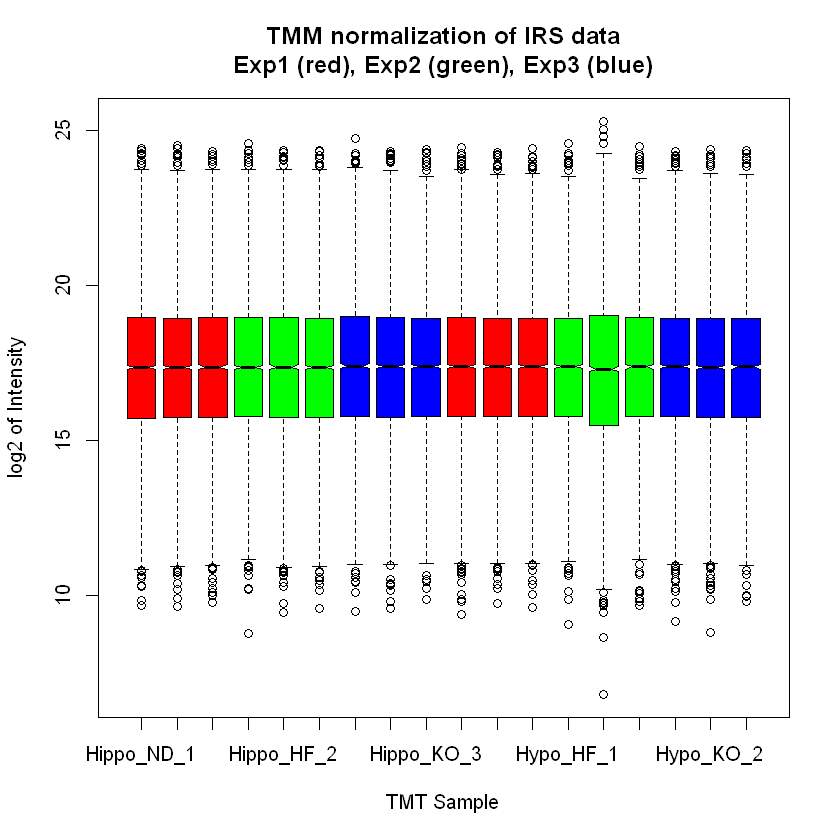

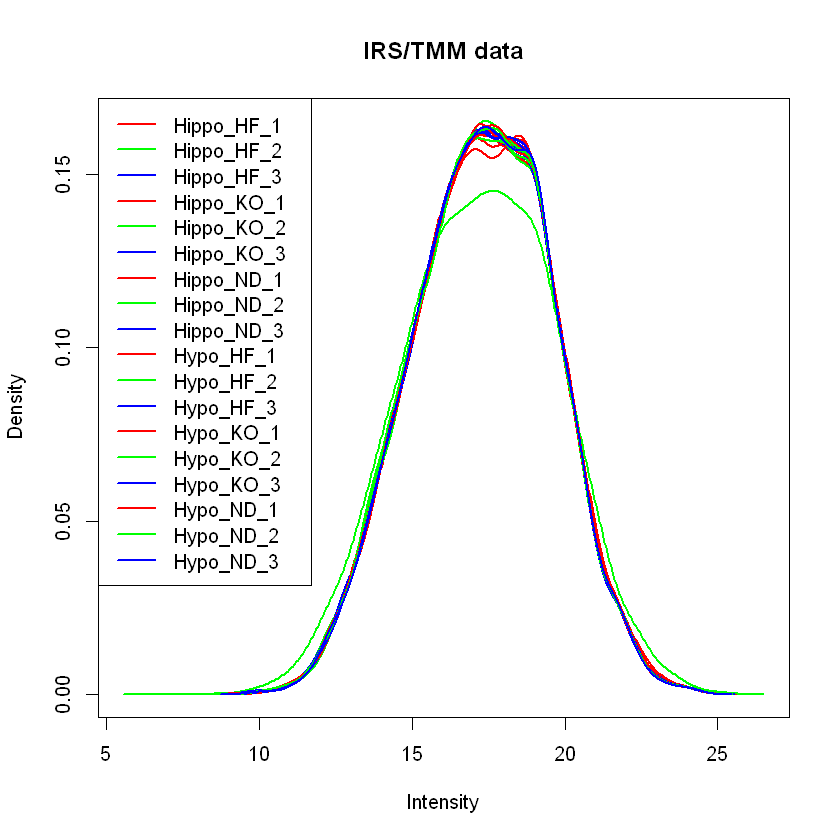

In [130]:
# see if box plots are aligned
boxplot(log2(data_irs_tmm), notch = TRUE, col = rep(c("red", "green", "blue"), each = 3), 
        main = "TMM normalization of IRS data\nExp1 (red), Exp2 (green), Exp3 (blue)",
        xlab = 'TMT Sample', ylab = 'log2 of Intensity')
# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_irs_tmm), col = rep(c("red", "green", "blue"), 6), main = "IRS/TMM data")


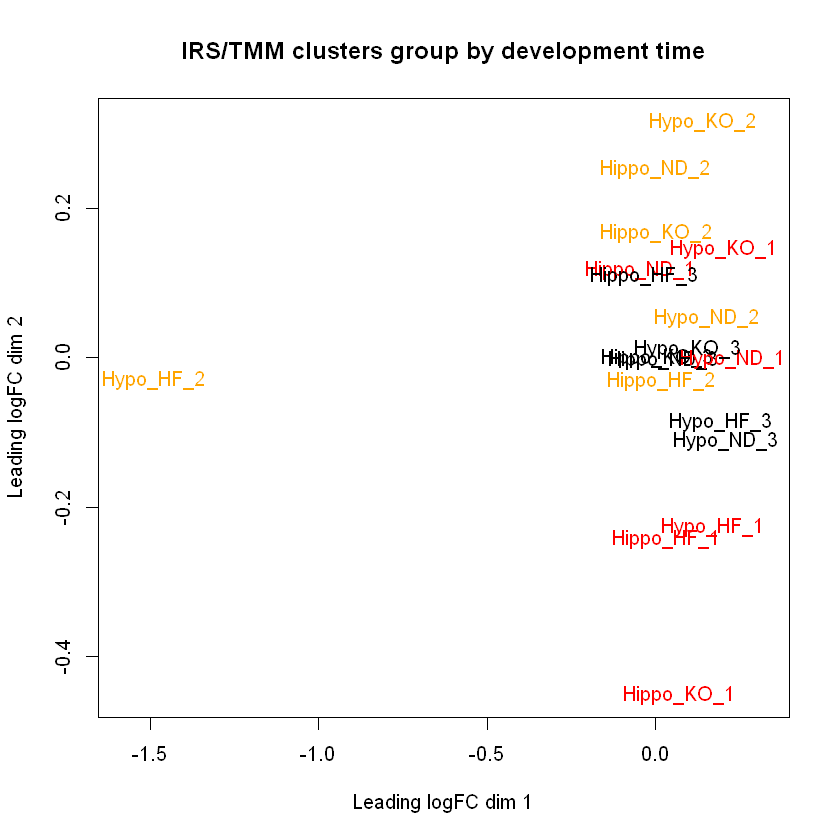

In [131]:
# see how things cluster after IRS plus TMM
col_vec <- c("red", "orange", "black")
plotMDS(log2(data_irs_tmm), col = col_vec, main = "IRS/TMM clusters group by development time")
write.table(data_irs_tmm,file = "data_irs_tmm.csv",sep = ",")

In [132]:
group <- c(rep("ND1", 3), rep("HF1", 3), rep("KO1", 3), rep("ND2", 3), rep("HF2", 3), rep("KO2", 3))
y <- DGEList(counts = data_irs, group = group, genes =accession )

Design matrix not provided. Switch to the classic mode.


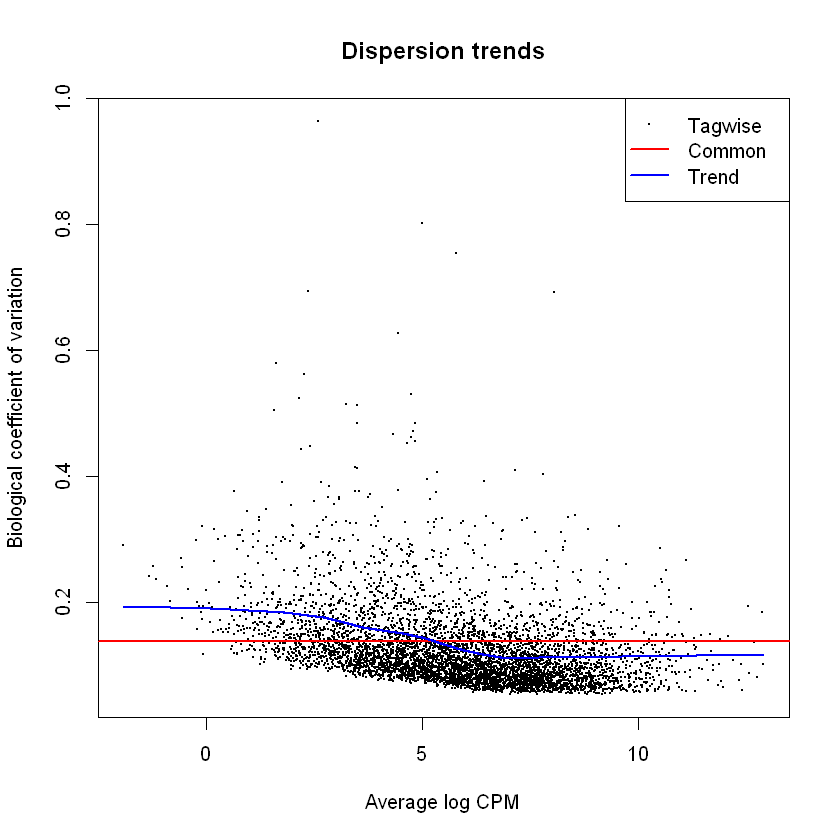

In [133]:
y <- calcNormFactors(y)
y <- estimateDisp(y)
plotBCV(y, main = "Dispersion trends")

In [134]:
#head(data_irs)

Hippo_ND_1,Hippo_ND_2,Hippo_ND_3,Hippo_HF_1,Hippo_HF_2,Hippo_HF_3,Hippo_KO_1,Hippo_KO_2,Hippo_KO_3,Hypo_ND_1,Hypo_ND_2,Hypo_ND_3,Hypo_HF_1,Hypo_HF_2,Hypo_HF_3,Hypo_KO_1,Hypo_KO_2,Hypo_KO_3
23407.61,27600.95,27960.52,24321.13,26121.83,26000.60,25705.17,24763.18,26493.76,27071.91,28025.39,26573.88,24745.59,15056.17,27434.64,26635.68,28419.60,28411.89
854017.19,897430.78,858674.59,793012.71,855855.24,858792.87,793063.96,928310.00,873925.37,882049.85,904924.74,844569.63,778016.11,658238.05,841748.66,948243.03,937322.53,917970.10
613386.66,646129.15,610221.69,531427.99,607333.88,584235.90,510465.55,650703.97,591830.41,603269.06,653186.09,601962.87,548277.95,317553.38,610251.70,664887.41,693763.97,652582.77
624447.57,655826.45,596589.48,548363.20,584224.05,576443.10,502824.41,664317.05,601216.79,592338.05,625293.99,563353.91,549916.75,566068.83,591580.47,617560.95,636385.32,611753.83
167108.75,166427.88,185497.22,196458.46,174902.14,181696.76,208573.18,182816.80,197153.68,182465.77,184924.82,183372.83,197630.47,152540.91,187993.70,190075.83,190849.49,190781.05
47996.91,50359.17,50224.53,45837.52,51456.81,51509.92,44953.31,50533.11,57624.47,51639.40,52425.98,55194.41,47583.53,27652.37,51484.48,58350.04,55036.77,51128.77


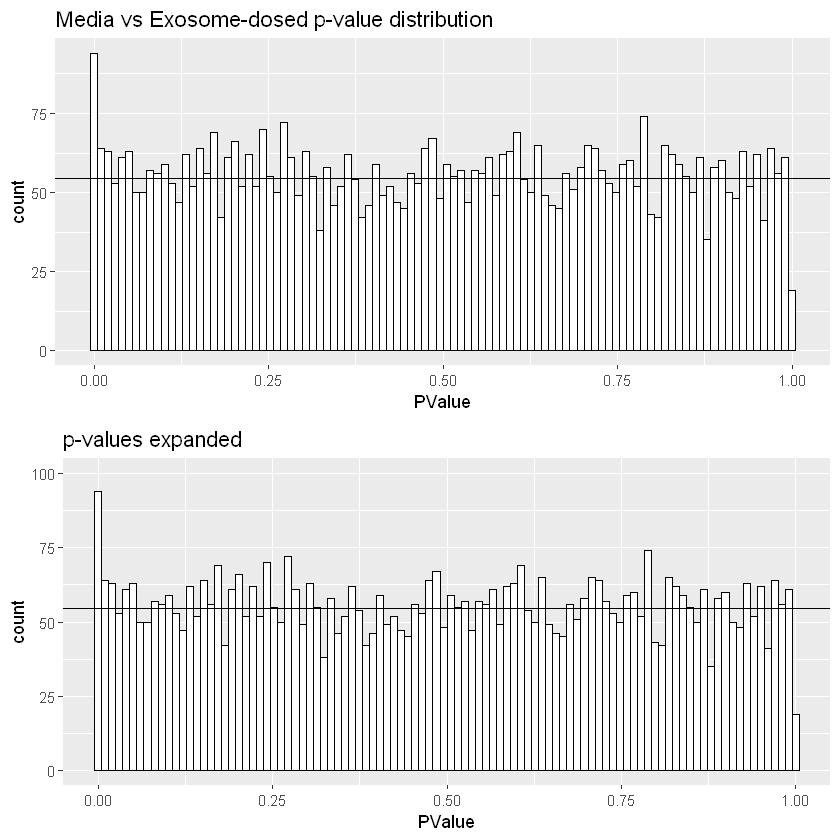

In [137]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("ND1",  "KO1"))
# make the results table 
M <- 1:3
E <- 7:9
tt <- topTags(et, n = Inf, sort.by = "none")$table
ND_KO_1 <- collect_results(data_irs_tmm, tt, M, "ND1", E, "KO1")
# check the p-value distrubution
pvalue_plots(ND_KO_1, 100, "Media vs Exosome-dosed")

In [138]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))
# see which proteins have the smallest p-values
topTags(et)$table

       KO1-ND1
Down        16
NotSig    5525
Up          29

,genes,logFC,logCPM,PValue,FDR
4975,E41L1_MOUSE,2.8861176,6.132281,9.125281e-177,5.082781e-173
458,SPA3K_MOUSE,2.1896387,5.481695,2.022112e-22,5.631582e-19
970,BACE1_MOUSE,-0.8072994,4.630825,4.738939e-18,8.798629e-15
5223,D3YXM0_MOUSE,2.1719662,3.434790,1.157516e-11,1.611841e-08
5153,A2AF31_MOUSE,1.8931932,5.131727,7.124863e-09,7.937097e-06
1226,NCHL1_MOUSE,0.4469170,8.329833,1.234908e-08,1.146406e-05
529,7B2_MOUSE,1.1056751,6.461910,1.781756e-07,1.417769e-04
2431,THNS2_MOUSE,-0.5928849,5.030766,1.469569e-06,1.004286e-03
1488,NLRX1_MOUSE,-0.5182931,5.933337,1.622724e-06,1.004286e-03
2950,CNST_MOUSE,0.6752269,3.620956,2.139196e-06,1.191532e-03


       ND2-ND1
Down         0
NotSig    5570
Up           0

,genes,logFC,logCPM,PValue,FDR
895,FABP7_MOUSE,0.3432433,6.4836130,0.004857775,1
5223,D3YXM0_MOUSE,-0.8664477,3.4347896,0.005063019,1
516,KCC2A_MOUSE,-2.3608555,8.0717140,0.006888628,1
957,CDD_MOUSE,0.3401354,3.0178073,0.008371769,1
1004,RAB2B_MOUSE,-0.2212801,4.8292992,0.013970805,1
1612,IQGA2_MOUSE,-0.4274400,5.4261530,0.021310898,1
4817,CAD13_MOUSE,0.2842244,7.7902440,0.025935946,1
777,TRAF2_MOUSE,-0.5147262,0.0711677,0.028173774,1
3231,IP3KA_MOUSE,-0.2078033,6.7876925,0.028406922,1
421,LAMB1_MOUSE,0.2483079,4.6800162,0.029295309,1


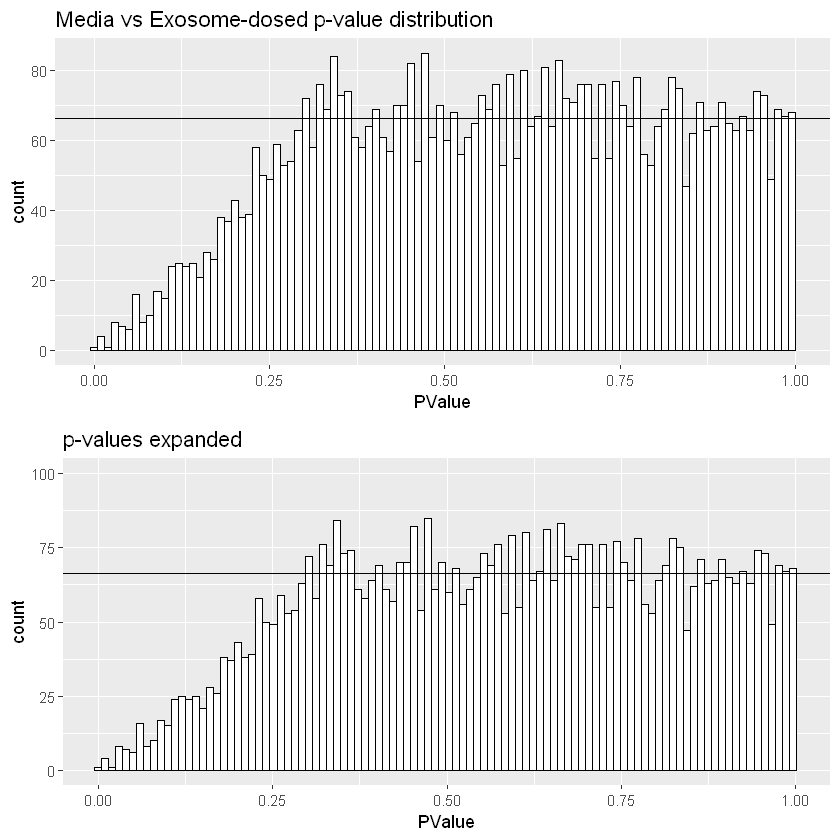

In [139]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("ND1",  "ND2"))
# make the results table 
M <- 1:3
E <- 10:12
tt <- topTags(et, n = Inf, sort.by = "none")$table
ND1_ND2 <- collect_results(data_irs_tmm, tt, M, "ND1", E, "ND2")
# check the p-value distrubution
pvalue_plots(ND1_ND2, 100, "Media vs Exosome-dosed")
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))
# see which proteins have the smallest p-values
topTags(et)$table

       KO2-KO1
Down         0
NotSig    5570
Up           0

,genes,logFC,logCPM,PValue,FDR
4815,AKA12_MOUSE,-0.4285652,8.494302,0.001129682,0.9980541
153,AKAP1_MOUSE,-0.5297874,4.573237,0.002042925,0.9980541
1107,A0A0N4SVK3_MOUSE,-0.4831772,2.653822,0.003542219,0.9980541
957,CDD_MOUSE,-0.3708993,3.017807,0.004043280,0.9980541
2668,UBP54_MOUSE,0.3225023,2.413856,0.004747469,0.9980541
2950,CNST_MOUSE,-0.3882050,3.620956,0.006267091,0.9980541
700,MRP_MOUSE,-0.6576914,6.312472,0.007689705,0.9980541
735,RANG_MOUSE,-0.4415134,6.939150,0.008071768,0.9980541
971,MCH_MOUSE,-0.5002454,5.374352,0.009621477,0.9980541
696,CELF1_MOUSE,0.2678073,6.274198,0.010545262,0.9980541


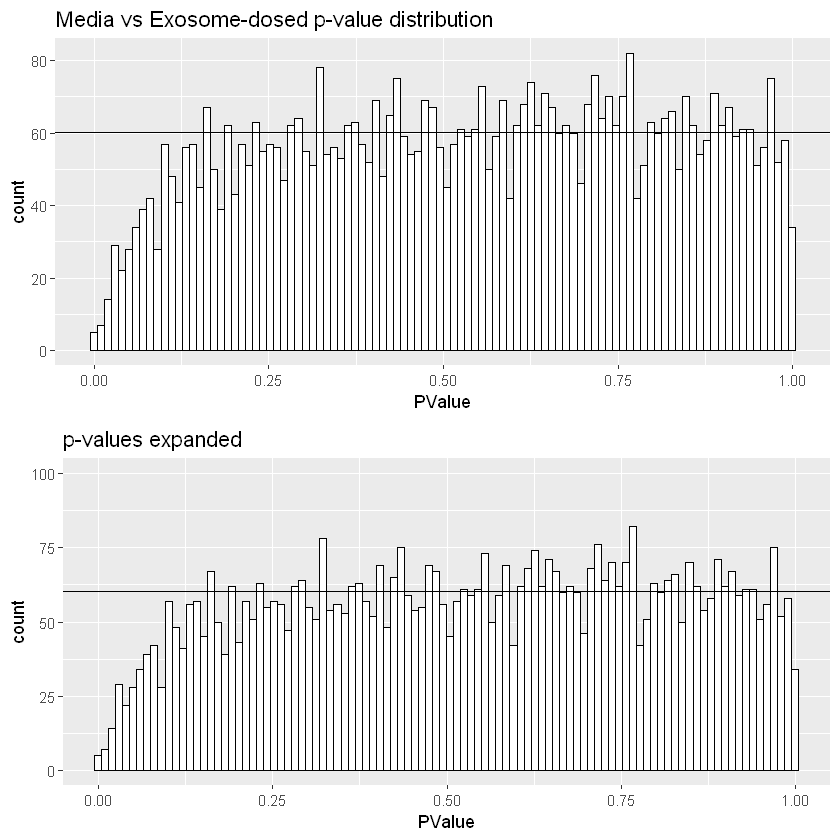

In [140]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("KO1",  "KO2"))
# make the results table 
M <- 1:3
E <- 10:12
tt <- topTags(et, n = Inf, sort.by = "none")$table
KO1_KO2 <- collect_results(data_irs_tmm, tt, M, "KO1", E, "KO2")
# check the p-value distrubution
pvalue_plots(KO1_KO2, 100, "Media vs Exosome-dosed")
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))
# see which proteins have the smallest p-values
topTags(et)$table

       KO2-ND2
Down        12
NotSig    5541
Up          17

,genes,logFC,logCPM,PValue,FDR
4975,E41L1_MOUSE,2.8883344,6.132281,5.297185e-177,2.950532e-173
970,BACE1_MOUSE,-1.0083354,4.630825,4.358513e-27,1.213846e-23
5223,D3YXM0_MOUSE,3.2197422,3.434790,5.405198e-22,1.003565e-18
458,SPA3K_MOUSE,1.8271001,5.481695,1.889459e-16,2.631071e-13
1226,NCHL1_MOUSE,0.6145146,8.329833,5.420438e-15,6.038367e-12
416,IGKC_MOUSE,-1.4524641,6.102694,1.924018e-09,1.557611e-06
2431,THNS2_MOUSE,-0.7403245,5.030766,1.957501e-09,1.557611e-06
2729,F177A_MOUSE,-1.0309358,6.300767,1.252655e-08,8.721611e-06
5407,G3X8T9_MOUSE,0.6731534,4.263823,3.979375e-08,2.462791e-05
403,RBM3_MOUSE,-0.7523923,5.780726,1.139203e-07,6.345361e-05


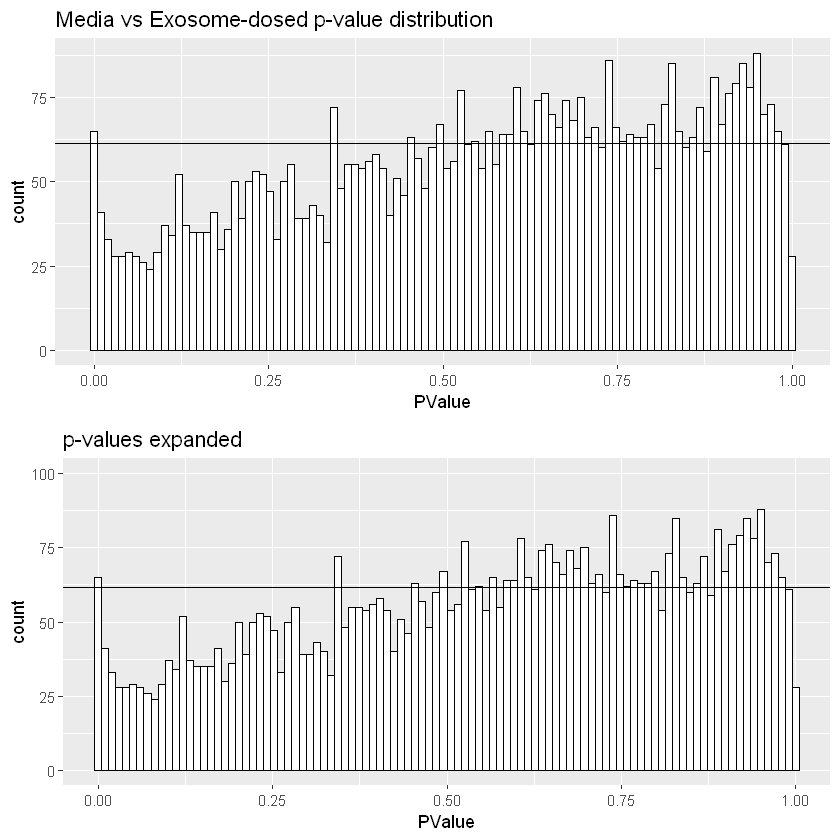

In [141]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("ND2",  "KO2"))
# make the results table 
M <- 10:12
E <- 16:18
tt <- topTags(et, n = Inf, sort.by = "none")$table
ND2_KO2 <- collect_results(data_irs_tmm, tt, M, "ND2", E, "KO2")
# check the p-value distrubution
pvalue_plots(ND2_KO2, 100, "Media vs Exosome-dosed")
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))
# see which proteins have the smallest p-values
topTags(et)$table